# Data Processing Notebook
This template script contains all the code needed to import and process Raman spectra, then save them in a standardised file format. It can import and process a single file, or multiple files at once. Available processing includes:
- Averaging for multi-spec measurements
- Baseline (background) subtraction
- Reference spectrum subtraction
- Automatic peak detection
- Automatic peak fitting

# Requires input data files to be organised as follows:
- Location: {Data_dir}/{Sample}/{Measurement Date}/
- Sample/Measurement metadata must be recorded in either file {spec filename}_MetaData.csv, or within spec filename
    - Spec filename format:
    
        {Spec ID number}\_{Sample}\_{Subsample}\_{notes}\_{Magnification}x\_{Laser wavelength}nm\_{Laser power}mW\_{Accumulations}x{Exposure time}.txt
    
    - Each spectrum file in a given project must have a unique identifier (preferable a sequential ID number) so that it can always be distinguished from other measurements, even when they are otherwise identical. These ID numbers can be used to refer to particular spectra when manually specifying settings to use for outliers/exceptional cases.
    - any pre-processing steps applied to the data should be included at the end of the filename
        - C: cosmic ray removal
        - O: outlier removal
        - N: normalisation
        
# How to use this script:
- Pick your directories and specify what sample/setting filters you want to apply when importing files
- Adjust the data import string to make sure it matches your file structure and naming conventions (if necessary)
- Each section of code starts with a set of user input variables to control what it does:

             skip: skip this section entirely (True/False)
            debug: print debug messages during execution (True/False)
        show_plot: show plotted figures in viewer (True/False)
        save_plot: save plotted figures to file (True/False)
        
    Data processing sections also need to be told what x,y values and keynames to use for input/output:
    
            x_key: the keyname to use as x values (e.g. 'raman_shift')
            y_key: the keyname to use as y values (e.g. 'y_av_sub')
          alt_key: the back-up keyname to use as y values if y_key does not exist for a given measurement (e.g. 'y_av')
          new_key: the keyname to save the output under (e.g. 'y_av_refsub' or 'fitted_peaks')
          
    Some processing steps also have manual overrides, for example if you want to specify what measurements need to have a reference spectrum subtracted, or which peak positions to fit for a given measurement. Please refer to those sections.

- To turn off/on sections of code, e.g. peak detection, simply use the 'skip' variable at the start of each section.
- When rerunning sections of code, bear in mind that data and variables will reflect the most recent state and may give you unexpected results - sometimes it's safer to rerun the whole script. 
- When you are happy with the output of a particular section, you can switch the 'debug' variable to False to hide debug text generated in the window. It will continue to show key information, and plots.
- To save time and memory, you can switch 'show_plot' to False to stop plots being rendered in the viewer. They will still be saved to disk if 'save_plot' is True.


In [1]:
# ==================================================
# define where your data is, and what files to import

# list directories for input data, figures and output files
Data_dir = './data/'
Fig_dir = './figures/'
Out_dir = './processed data/'
Ref_dir = './references/'

Technique = 'Raman'         # 'Raman' or 'FTIR'

# filter data import by sample / subsample
Sample = 'HR2-O'                # name of sample, or '*' for all
Subsample = '*'             # name of subsample, or '*'
Measurement_ID = '*'        # unique ID of measurement, or '*'

# list spectral IDs to skip when importing data, as strings
Do_Not_Import = []

# filter by measurement settings
Metadata_File = False       # set to True to import metadata file, or False to extract data from spec filename
Measurement_Date = '*'      # Date in YYYY-MM-DD format as string, or '*'
Laser_Wavelength = '*'      # wavelength (in nm) as integer, or '*'
Laser_Power = '*'           # power (in mW or %) as int/float, or '*'
Exposure_Time = '*'         # exposure time (in sec) as int/float, or '*'
Accumulations = '*'         # accumulations as int, or '*'
Magnification = '*'         # objective magnification as int, or '*'
Preprocessing = '*'         # specify required preprocessing, or '*' for best available

In [2]:
# ==================================================
# this section imports necessary python modules

import os
import math
import glob
import datetime
import numpy as np
import pandas as pd
import lmfit as lmfit
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.signal import savgol_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable

# import VibSpec module functions
from OSTRI_functions import *

"""
# ==================================================
# FILE SEARCH
# - this section searches for spectrum files that match the specified settings
# ==================================================
"""

print("SEARCHING FOR SPECTRUM DATA FILES...")

# find files
#   - currently requires data files to be named and organised as follows:
# Data_dir/{Sample}/{Measurement_Date}/{Measurement_ID}_{Sample}_{Subsample}_{Measurement Parameters}.txt
text = "%s%s/%s/%s_%s_%s*_%sX_%snm_%smW_%sx%ss*txt" % (Data_dir, Measurement_Date, Sample,
            Measurement_ID, Sample, Subsample, Magnification,
            Laser_Wavelength, Laser_Power, Accumulations, Exposure_Time)
print(text)
spec_dirs = sorted(glob.glob(text))

# trim to measurement ID numbers
Spec_IDs = np.unique([spec.split("/")[-1].split("_")[0] for spec in spec_dirs])
print()
print("spectrum IDs found:", Spec_IDs)

# find appropriate pre-processed file for each measurement
spec_dirs = []
for ID in Spec_IDs:
    if Preprocessing != '*':
        # use specified preprocessing
        text = "%s%s*/%s/%s_*_%s.txt" % (Data_dir, Measurement_Date, Sample, ID, Preprocessing)
        temp = sorted(glob.glob(text))
        if len(temp) > 0:
            lengths = [len(s) for s in temp]
            spec_dirs.append(temp[np.argmax(lengths)])
    else:
        # use best available
        text = "%s%s*/%s/%s_*.txt" % (Data_dir, Measurement_Date, Sample, ID)
        temp = sorted(glob.glob(text))
        if len(temp) > 0:
            lengths = [len(s) for s in temp]
            spec_dirs.append(temp[np.argmax(lengths)])

print()
print("data files found:", len(spec_dirs))
for file in spec_dirs:
    print("    ", file.split("/")[-1])
    

SEARCHING FOR SPECTRUM DATA FILES...
./data/*/HR2-O/*_HR2-O_**_*X_*nm_*mW_*x*s*txt

spectrum IDs found: ['0001' '0003' '0004' '0005' '0006' '0007' '0008']

data files found: 7
     0001_HR2-O_whitlockite_50X_532nm_1mW_5x1s_2024-10-24.txt
     0003_HR2-O_dentine_50X_785nm_10mW_25x1s_2024-10-24.txt
     0004_HR2-O_whitlockite_50X_785nm_10mW_25x1s_2024-10-24.txt
     0005_HR2-O_map1_50X_785nm_10mW_5x1s_2024-10-24.txt
     0006_HR2-O_map2_50X_785nm_10mW_5x1s_2024-10-24.txt
     0007_HR2-O_map3_50X_785nm_10mW_5x1s_2024-10-24.txt
     0008_HR2-O_resin_50X_785nm_10mW_25x1s_2024-10-24.txt


# Data import

- this section actually imports data files and extracts their metadata
- metadata can be in a separate CSV file with the same name plus '\_metadata', or can be extracted from the data file's name
- measurements are imported file by file, and added sequentially to the 'data' dict
- to access a specific measurement, you call data\[measurement ID\]\[key\], where 'key' is the type of data you want from it

In [3]:
print("IMPORTING DATA...")

# print debug messages?
debug = True

# set up data storage dictionary
data = {}

# ==================================================
# each measurement imported will be added to this dictionary as a Measurement object
# To access a particular measurement, use data[measurement ID]

# for each detected file
for spec_dir in spec_dirs:
    while True:
        try:
            filename = spec_dir.split("/")[-1][:-4]
            ID = filename.split("_")[0]
            if ID in Do_Not_Import:
                print()
                print(" measurement %s is in Do_Not_Import list, skipping" % filename)
                break
            else:
                print()
                print("importing %s" % filename)
                # extract sample/measurement metadata
                metadata = False
                if Metadata_File == True:
                    # search for metadata file with matching name
                    metadata_dir = glob.glob("%s_metadata.csv" % spec_dir[:-4])
                    print("    metadata files found:", len(metadata_dir))
                    if len(metadata_dir) > 0:
                        metadata = True
                if metadata == True:
                    # get metadata from metadata file
                    metadata = pd.read_csv(metadata_dir)
                else:
                    # get metadata from filename instead
                    date = datetime.datetime.strptime(spec_dir.split("/")[-3], "%Y-%m-%d")
                    filename_split = filename.split("_")
                    # get sample info
                    ID, sample, subsample = filename_split[:3]
                    # check for preprocessing
                    if len(filename_split[-1].split("x")) == 2 and filename_split[-1][-1] == 's':
                        # final item in filename is {Accumulations}x{Exposure_Time}s, no preprocessing
                        preprocessing = 'none'
                        # check for additional sample notes
                        notes = ''
                        if filename_split[2] != filename_split[-5]:
                            notes = "_".join(filename_split[3:-4])
                        mag, laser_wavelength, laser_power, accumxexp = filename_split[-4:]
                    else:
                        # final item in filename assumed to be preprocessing steps
                        preprocessing = filename_split[-1]
                        # check for additional sample notes
                        notes = ''
                        if filename_split[2] != filename_split[-6]:
                            notes = "_".join(filename_split[3:-5])
                            metadata_start = 4
                        mag, laser_wavelength, laser_power, accumxexp = filename_split[-5:-1]
                    mag = mag[:-1]  # remove 'X' from magnification
                    laser_wavelength = int(laser_wavelength[:-2])   # remove 'nm'
                    if laser_power[-2:] == 'mW':
                        # laser power in mW
                        laser_power = float(laser_power[:-2])   # remove 'mW'
                        power_unit = 'mW'
                    else:
                        # assume power in %
                        laser_power = float(laser_power[:-1])   # remove '%'
                        power_unit = "%%"
                    accumulations, exposure_time = accumxexp.split("x")
                    accumulations = int(accumulations)
                    exposure_time = float(exposure_time[:-1])   # remove 's'
                # report metadata
                if debug == True:
                    print("    measurement ID:", ID)
                    print("              sample:", sample)
                    print("           subsample:", subsample)
                    print("         measured on:", date.strftime("%Y-%m-%d"))
                    print("               notes:", notes)
                    print("    measurement settings:")
                    print("         magnification: %s X" % (mag))
                    print("            wavelength: %s nm" % (laser_wavelength))
                    print("                 power: %s %s" % (laser_power, power_unit))
                    print("              exposure: %s x %s seconds" % (accumulations, exposure_time))
                    print("    preprocessing: %s" % (preprocessing))
                # import spectrum file (assumes Renishaw file formatting with either 2 or 4 columns)
                spec = np.genfromtxt(spec_dir).transpose()
                if debug == True:
                    print("    spec array:", np.shape(spec))
                distances = []
                xy_coords = []
                if np.size(spec, axis=0) == 4:
                    # map or line, columns=(x_position, y_position, raman_shift, intensity)
                    spec_type = 'map'
                    # determine splits between stacked spectra
                    splits = np.ravel(np.where(np.roll(spec[2], 1) < spec[2]))
                    points = len(splits)
                    print("    spectral map, %s points" % (points))
                    # get X,Y coordinates (in um) for each point spectrum
                    x_pos = np.asarray(spec[0][splits])
                    y_pos = np.asarray(spec[1][splits])
                    xy_coords = np.asarray([x_pos, y_pos])
                    # determine if line, or map by looking at signs of dX, dY
                    dx = np.roll(x_pos, 1)[1:] - x_pos[1:]
                    dy = np.roll(y_pos, 1)[1:] - y_pos[1:]
                    dx_sign = np.sign(dx)
                    dy_sign = np.sign(dy)
                    if np.all(dx_sign == np.sign(np.mean(dx))) & np.all(dy_sign == np.sign(np.mean(dy))):
                        # checks if points follow a line
                        print("    measurement is a 1D line scan")
                        spec_type = 'line'
                        distances = np.cumsum(np.sqrt(dx**2 + dy**2))
                        distances = np.insert(distances, 0, 0)
                    else:
                        # assumes points are arranged in a grid
                        print("    measurement is a 2D map scan")
                    # extract shift, intensity spectrum for each point
                    x = np.asarray(np.split(spec[2], splits[1:]))[0]
                    y = np.asarray(np.split(spec[3], splits[1:]))
                else:
                    # single point, columns=(raman_shift, intensity)
                    spec_type = 'point'
                    points = 1
                    xy_coords = np.asarray([[0],[0]])
                    print("        single point measurement")
                    x = spec[0]
                    y = spec[1:]
                sort = np.argsort(x)
                x = x[sort]
                y = y.transpose()[sort,:]
                infcheck = np.any(np.isinf(y), axis=1)
                nancheck = np.any(np.isnan(y), axis=1)
                zerocheck = np.any(y == 0, axis=1)
                check = np.logical_or.reduce((infcheck, nancheck, zerocheck))
                if debug == True:
                    print("              shift:", np.shape(x))
                    print("          intensity:", np.shape(y))
                    print("        shift range: %0.f - %0.f cm-1" % (np.amin(x), np.amax(x)))
                    print("        inf check: %0.f/%0.f" % (np.count_nonzero(infcheck),
                                                               np.size(infcheck)))
                    print("        nan check: %0.f/%0.f" % (np.count_nonzero(nancheck),
                                                               np.size(nancheck)))
                    print("        zero check: %0.f/%0.f" % (np.count_nonzero(zerocheck),
                                                               np.size(zerocheck)))
                if np.count_nonzero(check) > 0.5 * np.size(check):
                    raise Exception("%0.f%% of spectrum data is 0/nan/inf! Cannot import!" % (100*np.count_nonzero(check)/np.size(check)))
                # get average spectrum (for single points, just use spec)
                y_av = np.mean(y, axis=0)
                # generate sample title for consistent naming
                title = "%s_%s_%s" % (ID, sample, subsample)
                if notes != '':
                    title += "_" + notes
                # create Measurement instance from imported data
                data[str(ID)] = Measurement(
                    ID=str(ID),
                    title=title,
                    filename=filename,
                    sample=sample,
                    subsample=subsample,
                    notes=notes,
                    x=x[~check],
                    y=y[~check],
                    ykey='y',
                    technique='Raman',
                    generate_average=True,
                    laser_wavelength=laser_wavelength,
                    spec_type=spec_type,
                    points=points,
                    magnification=mag,
                    laser_power=laser_power,
                    accumulations=accumulations,
                    exposure_time=exposure_time,
                    x_coords=xy_coords[0],
                    y_coords=xy_coords[1],
                    Fig_dir = Fig_dir,
                    Out_dir = Out_dir
                )
                
                print("    imported successfully!")
                break
        except Exception as e:
            print("    something went wrong! Exception:", e)
            break
        
print()
print("%s/%s files imported" % (len(data.keys()), len(spec_dirs)))

# report which files were imported and which were not
print()
print("Files found / imported")
for num in Spec_IDs:
    if num in data.keys():
        print("    ", num, u'\u2713', data[num]['filename'])
    else:
        text = ''
        if num in Do_Not_Import:
            text = 'ID in Do_Not_Import list'
        print("    ", num, 'X', text)

# update list of Spec IDs to only include imported spectra
Spec_IDs = list(data.keys())

samples = np.unique([data[num]['sample'] for num in Spec_IDs])
print()
print("samples in dataset:")
for sample in samples:
    print("    ", sample)

lasers = np.unique([measurement.laser_wavelength for ID, measurement in data.items()])
print()
print("laser wavelengths in dataset:")
for laser in lasers:
    print("    %s (%3.f measurements)" % (laser, len([ID for ID, measurement in data.items() if measurement.laser_wavelength == laser])))

IMPORTING DATA...

importing 0001_HR2-O_whitlockite_50X_532nm_1mW_5x1s_2024-10-24
    measurement ID: 0001
              sample: HR2-O
           subsample: whitlockite
         measured on: 2024-10-24
               notes: 
    measurement settings:
         magnification: 50 X
            wavelength: 532 nm
                 power: 1.0 mW
              exposure: 5 x 1.0 seconds
    preprocessing: 2024-10-24
    spec array: (2, 1015)
        single point measurement
              shift: (1015,)
          intensity: (1015, 1)
        shift range: 142 - 1702 cm-1
        inf check: 0/1015
        nan check: 0/1015
        zero check: 0/1015
    imported successfully!

importing 0003_HR2-O_dentine_50X_785nm_10mW_25x1s_2024-10-24
    measurement ID: 0003
              sample: HR2-O
           subsample: dentine
         measured on: 2024-10-24
               notes: 
    measurement settings:
         magnification: 50 X
            wavelength: 785 nm
                 power: 10.0 mW
       

# Baseline Subtraction
- baseline is a polynomial fitted to specified points along the x axis
- you can specify the points and polynomial order used for each wavelength, and add additional logic for specific samples if needed
- subtract_baseline() function finds the local average for each point ±25 cm-1, this value can be changed using the window argument
- automatically baselines each spectrum in a multi-spec measurement separately, individual spectra are stored in y_sub\[measurement index\]\[spec index\]
- y_av_sub is the baselined average spectrum
- y_sub_av is the average of the baselined spectra

DOING BASELINE SUBTRACTION

1/7 subtracting baseline for 0001_HR2-O_whitlockite


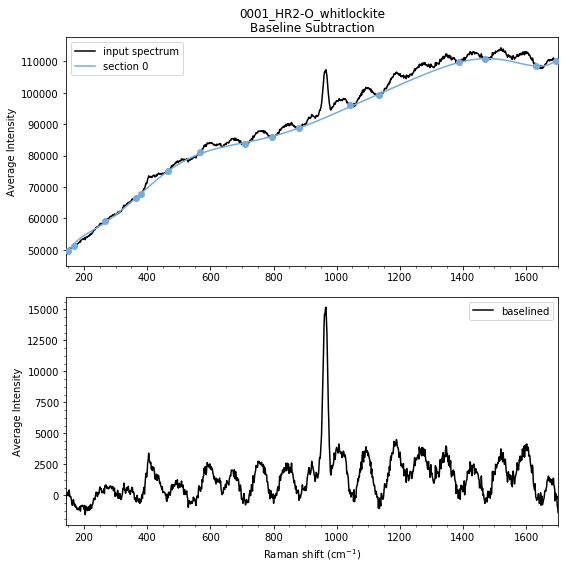

    baseline subtracted!

2/7 subtracting baseline for 0003_HR2-O_dentine


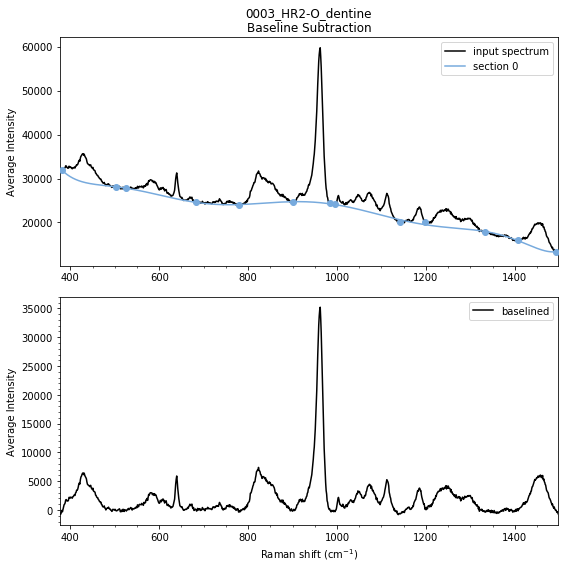

    baseline subtracted!

3/7 subtracting baseline for 0004_HR2-O_whitlockite


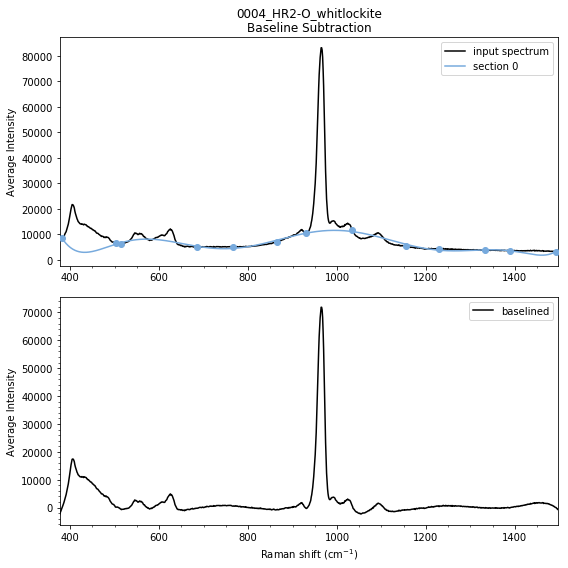

    baseline subtracted!

4/7 subtracting baseline for 0005_HR2-O_map1


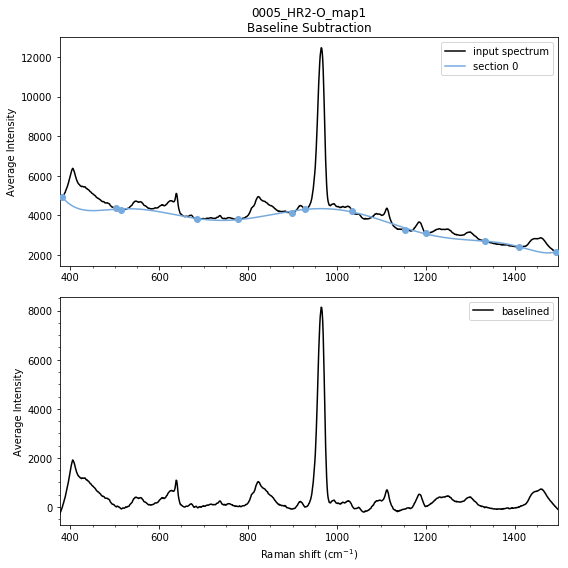

(1015, 80)


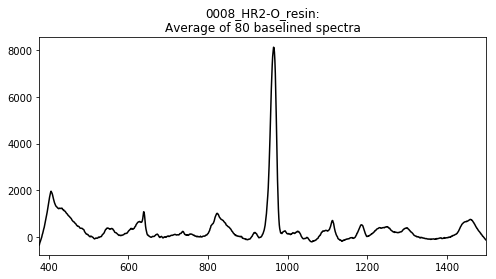

    baseline subtracted!

5/7 subtracting baseline for 0006_HR2-O_map2


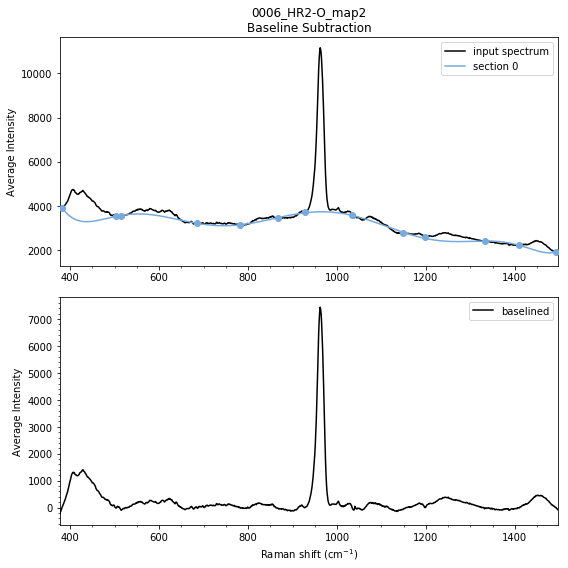

(1015, 42)


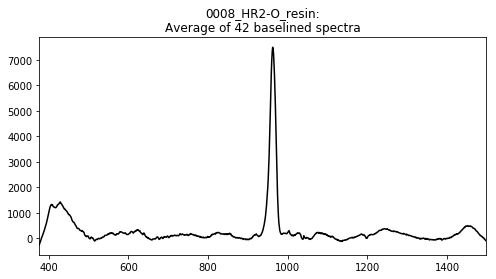

    baseline subtracted!

6/7 subtracting baseline for 0007_HR2-O_map3


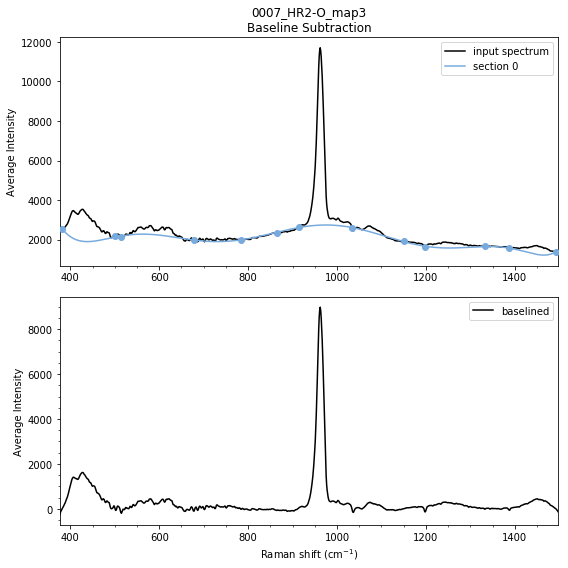

(1015, 215)


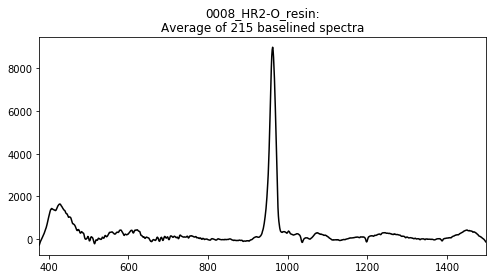

    baseline subtracted!

7/7 subtracting baseline for 0008_HR2-O_resin


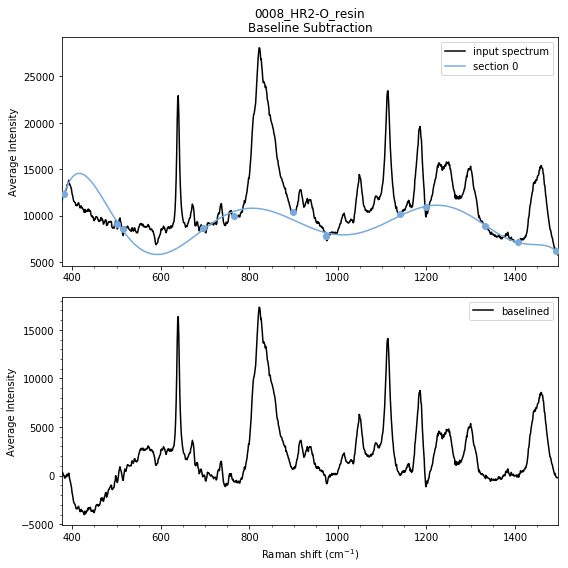

    baseline subtracted!


In [4]:
# skip this section?
skip = False

# print debug messages in viewer?
debug = False

# keyname of x value parameter to use ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use ('y_av')
y_key = 'y_av'

# new keyname for baselined spectrum
new_key = 'y_av_sub'

# x positions to use for fitting baseline
base_list = []

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

if skip == True:
    print("SKIPPING BASELINE SUBTRACTION")
    print("    (not recommended for Raman spectra)")
else:
    print("DOING BASELINE SUBTRACTION")

    process_count = 1
    for ID, measurement in data.items():
        print()
        print("%s/%s subtracting baseline for %s" % (process_count, len(data.keys()), measurement.title))

        # decide which set of baseline points to use
        if measurement.laser_wavelength == 532:
            base_list = [200, 300, 400, 415, 500, 600, 700, 800, 900, 1050, 1150, 1400, 1500, 1600,
                         1700, 1800, 2000, 2100, 2300, 2500, 2700, 2950, 3100, 3200, 3700, 3800, 3900, 4000]
            order = 11
        elif measurement.laser_wavelength in [633, 638]:
            base_list = [100, 200, 300, 400, 415, 500, 600, 700, 800, 900, 1050, 1150, 1400, 1500]
            order = 21
        elif measurement.laser_wavelength == 785:
            base_list = [150, 200, 250, 350, 475, 525, 660, 790, 900, 950, 1000, 1120, 1200, 1300, 1400, 1700, 1900, 2000, 2250, 2500,
                             2600, 2950, 3100, 3500, 3600, 3800]
            order = 11
        else:
            base_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1050, 1150, 1400, 1500]
            order = 11
        base_list = np.asarray(base_list)

        # subtract baseline from average spectrum
        subtract_baseline(measurement, x_key, y_key, new_key, base_list, base='polynomial', order=order,
                          fixed_ends=True, show_plot=show_plot, save_plot=save_plot, debug=debug)

        # baseline individual spectra if necessary
        if measurement.points > 1:
            if debug == True:
                print("%s points:" % title, measurement.points)
                print("    map x,y arrays:", np.shape(measurement['raman_shift']), np.shape(measurement['y']))
            # subtract baseline from individual spectra
            subtract_baseline(measurement, x_key, 'y', 'y_sub', base_list, base='poly', order=order,
                              fixed_ends=True, show_plot=False, save_plot=False, debug=debug)
            
            if show_plot == True:
                # plot average of baselines vs baseline of average
                plt.figure(figsize=(8,4))
                plt.title("%s:\nAverage of %s baselined spectra" % (title, measurement.points))
                ### need to add st.dev. handling to make this work
                ### plt.fill_between(spec['raman_shift'], np.mean(spec['y_sub'], axis=0)-np.std(spec['y_sub'],axis=0),
                        ### np.mean(spec['y_sub'], axis=0)+np.std(spec['y_sub'], axis=0), color='k', alpha=0.1, linewidth=0.)
                print(np.shape(measurement['y_sub'].y))
                plt.plot(measurement['raman_shift'], measurement['y_sub'].mean(), 'k')
                plt.xlim(measurement.x_start, measurement.x_end)
                plt.show()

            # get average of baselined spectra
            log = measurement['y_sub'].log + ['averaged over %s spectra' % measurement.points]
            measurement.add_spectrum(key='y_sub_av', y=measurement['y_sub'].mean(),
                    label='Averaged Baselined Intensity (counts)', log=log)
        process_count += 1
        print("    baseline subtracted!")

# Reference Spectrum Subtraction
- for specified spectra, subtract named reference spectrum
- works by interpolating reference spectrum to match target spectrum, rescaling reference spectrum to fit target spectrum at key positions, then subtracting reference from target
- requires processed reference spectrum to be in ./{Output_dir}/
- y_av_sub is the baselined average spectrum
- y_sub_av is the average of all baselined spectra

In [5]:
# skip this section?
skip = False

# print debug messages in viewer?
debug = True

# keyname of x value parameter to use ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use - defined for each reference in subtraction_refs dict

# back-up keyname if y_key does not exist
alt_key = 'y_av_sub'

# keyname for new spectrum
new_key = 'y_av_sub_refsub'

# for each reference spectrum being used, add its spec ID to this dict as follows:
# ref ID: {
#   'name': 'glass', # name of reference
#   'targets': [],  # list of spec IDs to subtract this reference from
#   'x_list': []    # list of x positions to fit when rescaling reference to match y values of target
# }
subtraction_refs = {
    'BOsc-532nm': { # background oscillation (532 nm only)
        'name': 'oscillation',
        'key': 'y_av_sub',
        'targets': [ID for ID, measurement in data.items() if measurement.laser_wavelength == 532],
        'x_list': [300, 350, 400, 450, 500, 550, 600, 650, 750, 800, 850, 900, 950, 1150, 1200, 1250, 1300, 1350, 1400,
                  1550, 1600, 1650, 1700, 1750, 1800],
        'add_polynomial': False,
        'poly_order': 5,
        'rerun_baseline': True
    }
}

# show plots in viewer?
show_plot = True

# save plots to file?
save_plot = True

if skip == True:
    print("SKIPPING REF SPECTRA IMPORT")
else:
    print("DOING REF SPECTRA IMPORT")
    
    # data storage array for reference spectra
    ref_data = {}
    
    # check which references need to be imported
    refs_for_import = []
    for ref, ref_info in subtraction_refs.items():
        targets = ref_info['targets']
        check = np.any(np.asarray([target in Spec_IDs for target in targets]))
        if check == True:
            refs_for_import.append(ref)

    print()
    print("references to import:")
    for ref_ID in refs_for_import:
        print("    ", ref_ID)

    # import processed reference spectra
    for ref_ID in refs_for_import:
        # get info from dict
        ref_name = subtraction_refs[ref_ID]['name']
        targets = [target for target in subtraction_refs[ref_ID]['targets'] if target in Spec_IDs]
        x_list = subtraction_refs[ref_ID]['x_list']
        rerun = subtraction_refs[ref_ID]['rerun_baseline']
        add_poly = subtraction_refs[ref_ID]['add_polynomial']
        poly_order = subtraction_refs[ref_ID]['poly_order']
        key = subtraction_refs[ref_ID]['key']
        print()
        print("reference:", ref_ID, ref_name)
        print("    to be subtracted from:", targets)
        print("    x_list for fitting:", x_list)
        # check if ref is in imported data
        success = False
        if ref_ID in Spec_IDs:
            # use currently-imported spectrum if possible
            if hasattr(data[str(ref_ID)], 'y_av_sub'):
                print("    using currently-imported data for %s" % ref_ID)
                # add link to data storage array
                ref_data[str(ref_ID)] = data[str(ref_ID)]
                ref_data[str(ref_ID)].name = ref_name
                ref_data[str(ref_ID)].targets = targets
                ref_data[str(ref_ID)].x_list = x_list
                ref_data[str(ref_ID)].rerun_baseline = rerun
                ref_data[str(ref_ID)].sub_key = key
                ref_data[str(ref_ID)].add_polynomial = add_poly
                ref_data[str(ref_ID)].poly_order = poly_order
                success = True
        if success == False:
            # find output spectrum file instead
            print("    searching for processed data file...")
            meta_dirs = glob.glob("%s*/*/*/%s_*_metadata.csv" % (Ref_dir, ref_ID))
            spec_dirs = glob.glob("%s*/*/*/%s_*_av-spectrum.csv" % (Ref_dir, ref_ID))
            print("        metadata files found:", len(meta_dirs))
            print("        spectrum files found:", len(spec_dirs))

            if len(meta_dirs) > 0 and len(spec_dirs) > 0:
                # import spectrum file
                meta = pd.read_csv(meta_dirs[0], index_col=0)
                print("    imported metadata:", meta.index.values)
                spec = pd.read_csv(spec_dirs[0])
                print("    imported spec array:", np.shape(spec))
                print(spec.info())
                # convert metadata to dict for passing to a new Measurement
                kwargs = {key: meta.loc[key][0] for key in meta.index.values}
                # add any missing info required for a reference Measurement
                kwargs['name'] = ref_name
                kwargs['targets'] = targets
                kwargs['targets'] = list(targets)
                kwargs['x_list'] = x_list
                kwargs['rerun_baseline'] = rerun
                kwargs['add_polynomial'] = add_poly
                kwargs['poly_order'] = poly_order
                kwargs['sub_key'] = key
                # add x,y data from spec
                kwargs['x'] = spec['Raman Shift (cm-1)']
                kwargs['y'] = spec['Baselined Intensity']
                kwargs['ykey'] = 'y_av_sub'

                # add to ref_data storage array
                ref_data[str(ref_ID)] = Measurement(
                    Fig_dir = Fig_dir,
                    Out_dir = Out_dir,
                    **kwargs
                )

DOING REF SPECTRA IMPORT

references to import:
     BOsc-532nm

reference: BOsc-532nm oscillation
    to be subtracted from: ['0001']
    x_list for fitting: [300, 350, 400, 450, 500, 550, 600, 650, 750, 800, 850, 900, 950, 1150, 1200, 1250, 1300, 1350, 1400, 1550, 1600, 1650, 1700, 1750, 1800]
    searching for processed data file...
        metadata files found: 1
        spectrum files found: 1
    imported metadata: ['ID' 'title' 'sample' 'technique' 'laser_wavelength' 'name' 'xlabel'
 'x_start' 'x_end' 'fig_dir' 'out_dir']
    imported spec array: (6001, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6001 entries, 0 to 6000
Data columns (total 4 columns):
Wavelength (nm)                   6001 non-null float64
Raman Shift (cm-1)                6001 non-null float64
Baselined Intensity               6001 non-null float64
Normalised Baselined Intensity    6001 non-null float64
dtypes: float64(4)
memory usage: 187.6 KB
None


DOING REFERENCE SPECTRUM SUBTRACTION

reference BOsc-532nm (oscillation)...
    applies to measurements: ['0001']

    1/1 subtracting oscillation from 0001_HR2-O_whitlockite

running reference subtraction on measurement 0001_HR2-O_whitlockite using oscillation
    input ref arrays: (6001,) (6001,)
    input target arrays: (1015,) (1015, 1)
    previous y processing: averaged 1 spectra
baselined using polynomial
    smoothed y array: (1015, 1)
    x_list for fitting:
         [ 300  350  400  450  500  550  600  650  750  800  850  900  950 1150
 1200 1250 1300 1350 1400 1550 1600 1650]
        point 1 :  299.75 -0.011534775268388925
        point 2 :  349.75 -0.03619762903930337
        point 3 :  399.75 -0.053922426903672015
        point 4 :  449.75 -0.044324397938245774
        point 5 :  499.75 0.05398174290579546
        point 6 :  549.75 -0.029019874347758018
        point 7 :  599.75 0.11944105567200129
        point 8 :  649.75 0.06964627916033148
        point 9 :  749.75 0.1

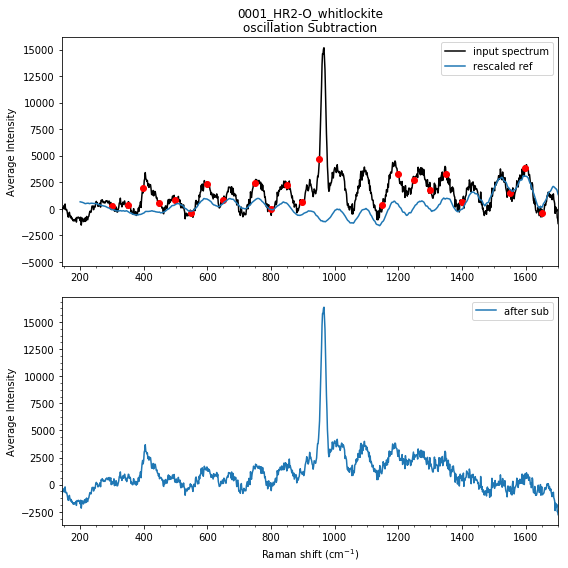

    end of subtract_reference function

running baseline subtraction on measurement 0001_HR2-O_whitlockite
    input arrays: raman_shift (1015,) y_av_sub_refsub (1015, 1)
    previous y processing: averaged 1 spectra
baselined using polynomial
oscillation fitted and subtracted
    x range: 142 - 1702
    x_list for subtraction: [ 200  250  300  350  400  415  500  600  700  800  900 1050 1150 1300
 1400 1500 1600]
    polynomial order: 16
    no spectrum splitting
    section 0 x, y arrays: (1015,) (1015, 1)
        section 0 x range: 142.3 - 1701.6 cm-1
        spectrum 0
         [203.375, 216.900391, 317.820312, 317.820312, 377.914062, 381.242188, 529.796875, 570.626953, 711.167969, 800.308594, 882.119141, 1058.121094, 1133.818359, 1307.263672, 1407.066406, 1490.902344, 1632.474609]
        point 1 :  202.5283203 -1652.543491889492
        point 2 :  216.0541017 -1533.1267972689259
        point 3 :  316.9820312 256.53975185688665
        point 4 :  316.9820312 256.53975185688665
  

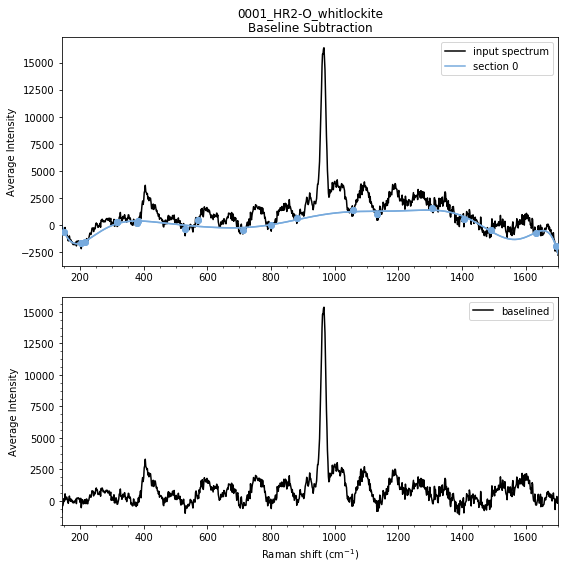

    end of subtract_baseline function
        reference subtracted!


In [6]:
if skip == True:
    print("SKIPPING REFERENCE SPECTRUM SUBTRACTION")
else:
    print("DOING REFERENCE SPECTRUM SUBTRACTION")

    if len(ref_data.keys()) == 0:
        print()
        print("no references imported!")

    # proceed with subtraction, ref by ref
    for ref_ID, ref in ref_data.items():
        # get ref info from dict
        ref_name = ref.name
        key = ref.sub_key
        targets = ref.targets
        x_list = ref.x_list
        add_poly = ref.add_polynomial
        poly_order = ref.poly_order
        print()
        print("reference %s (%s)..." % (ref_ID, ref_name))
        print("    applies to measurements:", targets)
        

        # for each measurement in target list
        process_count = 1
        for target_ID in targets:
            measurement = data[target_ID]
            print()
            print("    %s/%s subtracting %s from %s" % (process_count, len(targets), ref_name, measurement.title))
                
            subtract_reference(ref, measurement, x_key, key, alt_key, new_key, x_list, add_polynomial=add_poly,
                               poly_order=poly_order, save_plot=save_plot, show_plot=show_plot, debug=debug)

            if ref.rerun_baseline == True:
                # decide which set of baseline points to use
                if measurement.laser_wavelength == 532:
                    base_list = [200, 250, 300, 350, 400, 415, 500, 600, 700, 800, 900, 1050, 1150, 1300, 1400, 1500, 1600,
                                 1700, 1800, 2000, 2100, 2300, 2500, 2700, 2950, 3100, 3200, 3700, 3800, 3900, 4000]
                    order = 19
                elif measurement.laser_wavelength in [633, 638]:
                    base_list = [100, 200, 300, 400, 415, 500, 600, 700, 800, 900, 1050, 1150, 1400, 1500]
                    order = 11
                elif measurement.laser_wavelength == 785:
                    base_list = [250, 350, 475, 525, 660, 790, 900, 950, 1000, 1200, 1300, 1700, 1900, 2000, 2250, 2500,
                                     2600, 2950, 3100, 3500, 3600, 3800]
                    order = 11
                else:
                    base_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1050, 1150, 1400, 1500]
                    order = 11
                base_list = np.asarray(base_list)

                # subtract baseline from average spectrum
                subtract_baseline(measurement, x_key, new_key, new_key,
                        base_list, base='polynomial', order=order, fixed_ends=True,
                        show_plot=show_plot, save_plot=save_plot, plot_name='baselined2', debug=debug)
            process_count += 1
            print("        reference subtracted!")

## Plot against References

In [7]:
# skip this section?
skip = False

# set whether to print debug messages in this section
debug = True

# keyname for x values to plot ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use
y_key = 'y_av_sub'

# back-up keyname if y_key does not exist
alt_key = 'y_av_sub'

# label for X axis
x_label = "Raman Shift (cm$^{-1}$)"

# label for Y axis
y_label = 'Normalised Intensity'

# X range for plotting
x_start, x_end = (400, 1500)

# normalise data before plotting?
normalise = True

# offset spectra by this much (0 for no offset)
offset = 1.2

# group spectra by this parameter
grouping = 'sample'

# plot average spectra?
plot_average = True

# ==================================================
# import reference spectra

comparison_refs = {
    'RRUFF hydroxyapatite': {
        'name': 'HA ref',
        'sample': 'hydroxyapatite',
        'targets': ['0003']
    },
    'RRUFF whitlockite': {
        'name': 'whit. ref',
        'sample': 'whitlockite',
        'targets': ['0004']
    }
}

if skip == True:
    print("SKIPPING REF SPECTRA IMPORT")
else:
    print("DOING REF SPECTRA IMPORT")
    
    # check which references need to be imported
    refs_for_import = []
    for ref, ref_info in comparison_refs.items():
        targets = ref_info['targets']
        check = np.any(np.asarray([target in Spec_IDs for target in targets]))
        if check == True:
            refs_for_import.append(ref)

    print()
    print("references to import:")
    for ref_ID in refs_for_import:
        print("    ", ref_ID)

    # import processed reference spectra
    for ref_ID in refs_for_import:
        # get info from dict
        ref_name = comparison_refs[ref_ID]['name']
        ref_sample = comparison_refs[ref_ID]['sample']
        targets = [target for target in comparison_refs[ref_ID]['targets'] if target in Spec_IDs]
        print()
        print("reference:", ref_ID, ref_name)
        print("    to be compared to:", targets)
        # check if ref is in imported data
        success = False
        if ref_ID in Spec_IDs:
            # use currently-imported spectrum if possible
            if hasattr(data[str(ref_ID)], 'y_av_sub'):
                print("    using currently-imported data for %s" % ref_ID)
                # add link to data storage array
                ref_data[str(ref_ID)] = data[str(ref_ID)]
                ref_data[str(ref_ID)].name = ref_name
                ref_data[str(ref_ID)].targets = targets
                success = True
                
        if success == False:
            # find output spectrum file if possible
            print("    searching for processed data file...")
            meta_dirs = glob.glob("%s*/*/*/%s_*_metadata.csv" % (Ref_dir, ref_ID))
            spec_dirs = glob.glob("%s*/*/*/%s_*_av-spectrum.csv" % (Ref_dir, ref_ID))
            print("        metadata files found:", len(meta_dirs))
            print("        spectrum files found:", len(spec_dirs))

            if len(meta_dirs) > 0 and len(spec_dirs) > 0:
                # import spectrum file
                meta = pd.read_csv(meta_dirs[0], index_col=0)
                print("    imported metadata:", meta.index.values)
                spec = pd.read_csv(spec_dirs[0])
                print("    imported spec array:", np.shape(spec))
                print(spec.info())
                # convert metadata to dict for passing to a new Measurement
                kwargs = {key: meta.loc[key][0] for key in meta.index.values}
                # add any missing info required for a reference Measurement
                kwargs['name'] = ref_name
                kwargs['targets'] = targets
                kwargs['targets'] = list(targets)
                kwargs['x_list'] = x_list
                kwargs['rerun_baseline'] = rerun
                kwargs['add_polynomial'] = add_poly
                kwargs['poly_order'] = poly_order
                kwargs['sub_key'] = key
                # add x,y data from spec
                kwargs['x'] = spec['Raman Shift (cm-1)']
                kwargs['y'] = spec['Baselined Intensity']
                kwargs['ykey'] = 'y_av_sub'

                # add to ref_data storage array
                ref_data[str(ref_ID)] = Measurement(
                    Fig_dir = Fig_dir,
                    Out_dir = Out_dir,
                    **kwargs
                )
                success = True
                
        if success == False:
            # find RRUFF spectrum file instead
            print("    searching for RRUFF data file...")
            spec_dirs = glob.glob("%s%s/*/*.txt" % (Ref_dir, ref_ID))
            print("        spectrum files found:", len(spec_dirs))

            if len(spec_dirs) > 0:
                # import spectrum file
                spec = np.genfromtxt(spec_dirs[0], skip_header=10, delimiter=', ').transpose()
                print("    imported spec array:", np.shape(spec))
                # add any missing info required for a reference Measurement
                filename_split = spec_dirs[0].split("/")[-1][:-4].split("__")
                sample, rruff_ID, technique, laser_wavelength = filename_split[:4]
                laser_wavelength = int(laser_wavelength)
                if debug == True:
                    print("        RRUFF sample:", sample)
                    print("            RRUFF ID:", rruff_ID)
                    print("           technique:", technique)
                    print("    laser wavelength: %0.f nm" % laser_wavelength)
                    print("    x range: %0.1f-%0.1f" % (spec[0,0], spec[0,-1]))
                    print("    y range: %0.1f-%0.1f" % (np.amin(spec[1]), np.amax(spec[1])))
                kwargs = {'ID': ref_ID, 'name': ref_name, 'title': ref_ID, 'sample': sample, 'technique': technique, 'RRUFF_ID': rruff_ID,
                          'laser_wavelength': laser_wavelength, 'targets': list(targets)}
                kwargs['name'] = ref_name
                kwargs['targets'] = list(targets)
                # add x,y data from spec
                kwargs['x'] = spec[0]
                kwargs['y'] = spec[1]
                kwargs['ykey'] = 'y_av_sub'

                # add to ref_data storage array
                ref_data[str(ref_ID)] = Measurement(
                    Fig_dir = Fig_dir,
                    Out_dir = Out_dir,
                    **kwargs
                )

DOING REF SPECTRA IMPORT

references to import:
     RRUFF hydroxyapatite
     RRUFF whitlockite

reference: RRUFF hydroxyapatite HA ref
    to be compared to: ['0003']
    searching for processed data file...
        metadata files found: 0
        spectrum files found: 0
    searching for RRUFF data file...
        spectrum files found: 1
    imported spec array: (2, 2155)
        RRUFF sample: Hydroxylapatite
            RRUFF ID: R060180
           technique: Raman
    laser wavelength: 780 nm
    x range: 150.4-1188.8
    y range: -0.3-684.2

reference: RRUFF whitlockite whit. ref
    to be compared to: ['0004']
    searching for processed data file...
        metadata files found: 0
        spectrum files found: 0
    searching for RRUFF data file...
        spectrum files found: 1
    imported spec array: (2, 2477)
        RRUFF sample: Whitlockite
            RRUFF ID: R080052
           technique: Raman
    laser wavelength: 780 nm
    x range: 93.5-1287.2
    y range: 0.0-365

PLOTTING SAMPLE COMPARISONS


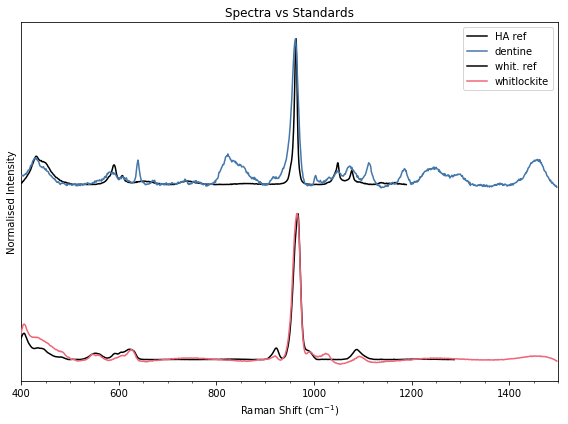

In [8]:
# ==================================================
# plot comparison
        
if skip == True:
    print("SKIPPING SAMPLE COMPARISON")
else:
    print("PLOTTING SAMPLE COMPARISONS")

    # determine how many reference groups there are for plotting
    groups = []
    for ref_ID in comparison_refs.keys():
        if ref_ID in ref_data.keys():
            groups.append(ref_ID)
        
    plt.figure(figsize=(8,2+2*len(groups)))
    plt.title("Spectra vs Standards")
    plt.xlabel(x_label)
    plt.xlim(x_start, x_end)
    plt.ylabel(y_label)
    plt.yticks([])
        
    count = 0
    # plot spectra for each group separately
    for ref_ID in groups:
        result = ref_data[ref_ID]['targets']
        spec_count = len(result) + 1
        
        # plot reference
        x, y = get_plot_data(ref_data[ref_ID], x_key, 'y_av_sub', normalise=True)
        label = getattr(ref_data[ref_ID], 'name', ref_ID)
        plt.plot(x, y - count*offset, 'k', label=label, zorder=2)
        
        # plot sample spectra
        for ID in result:
            x, y = get_plot_data(data[ID], x_key, y_key, normalise=True)
            label = getattr(data[ID], 'subsample', ID)
            plt.plot(x, y - count*offset, Colour_List[count % len(Colour_List)], label=label, zorder=3)
        count += 1

    plt.legend(loc=1)
    plt.minorticks_on()
    plt.tight_layout()
    if save_plot == True:
        plt.savefig("%s%s_refs.png" % (Fig_dir, grouping), dpi=300)
    if show_plot == True:
        plt.show()
    else:
        plt.close()

# Peak Detection
- searches for local maxima that meet two thresholds:
    1) relative intensity (vs maximum)
    2) signal:noise ratio
- produces figure showing which maxima passed and failed
- also shows any manually specified maxima from Manual_Peaks[spec ID]

In [9]:
# skip this section?
skip = False

# print debug messages in viewer?
debug = False

# minimum signal:noise ratio threshold
SNR_threshold=10

# minimum intensity threshold relative to max
norm_threshold=0.05

# minimum peak-peak separation
min_sep=20

# keyname of x value parameter to use ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use
y_key = 'y_av_sub_refsub'

# back-up keyname if y_key does not exist
alt_key = 'y_av_sub'

# keyname for detected peak table
new_key ='detected-peaks'

# show plot in viewer?
show_plot = True

# save plots to file?
save_plot = True

DOING AUTOMATIC PEAK DETECTION

1/7 detecting peaks for 0001_HR2-O_whitlockite

running peak detection on measurement 0001_HR2-O_whitlockite
    total 1 potential peaks found across 1 spectra

saving peak fit data to file


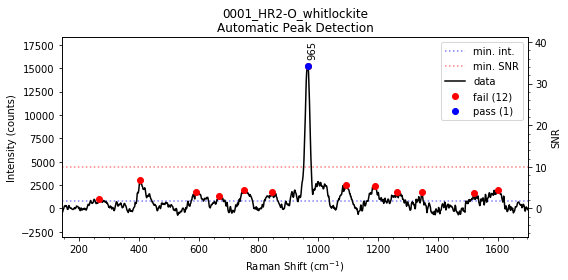

    done!

2/7 detecting peaks for 0003_HR2-O_dentine

running peak detection on measurement 0003_HR2-O_dentine
    total 11 potential peaks found across 1 spectra

saving peak fit data to file


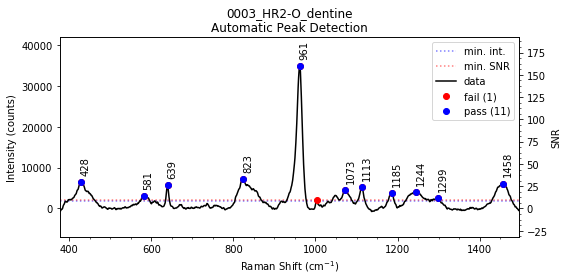

    done!

3/7 detecting peaks for 0004_HR2-O_whitlockite

running peak detection on measurement 0004_HR2-O_whitlockite
    total 3 potential peaks found across 1 spectra

saving peak fit data to file


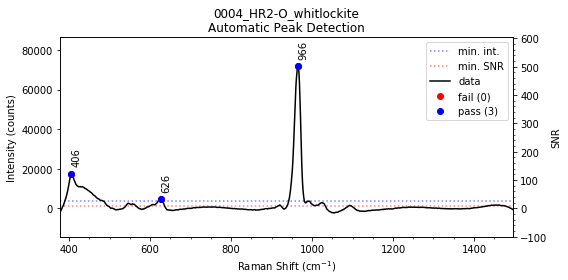

    done!

4/7 detecting peaks for 0005_HR2-O_map1

running peak detection on measurement 0005_HR2-O_map1
    total 9 potential peaks found across 1 spectra

saving peak fit data to file


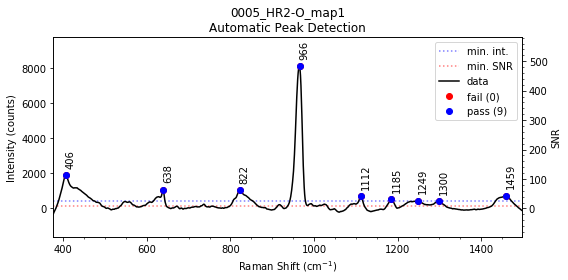

    done!

5/7 detecting peaks for 0006_HR2-O_map2

running peak detection on measurement 0006_HR2-O_map2
    total 4 potential peaks found across 1 spectra

saving peak fit data to file


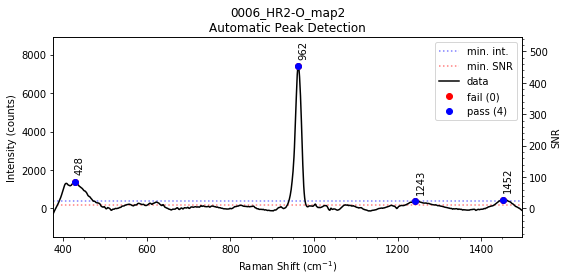

    done!

6/7 detecting peaks for 0007_HR2-O_map3

running peak detection on measurement 0007_HR2-O_map3
    total 2 potential peaks found across 1 spectra

saving peak fit data to file


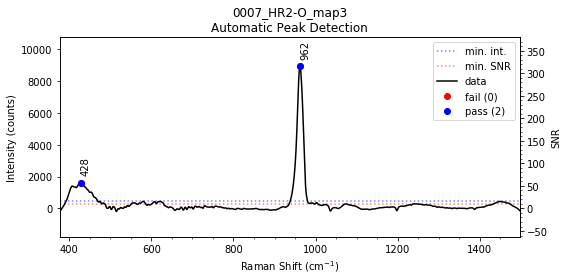

    done!

7/7 detecting peaks for 0008_HR2-O_resin

running peak detection on measurement 0008_HR2-O_resin
    total 10 potential peaks found across 1 spectra

saving peak fit data to file


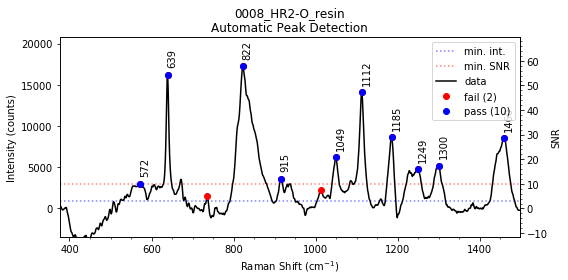

    done!


In [10]:
if skip == True:
    print("SKIPPING AUTOMATIC PEAK DETECTION")
else:
    print("DOING AUTOMATIC PEAK DETECTION")

    process_count = 1
    for ID, measurement in data.items():
        print()
        print("%s/%s detecting peaks for %s" % (process_count, len(data.keys()), measurement.title))

        if hasattr(measurement, y_key) == True:
            temp = y_key
        else:
            temp = alt_key

        detect_peaks(measurement, x_key, temp, new_key, SNR_threshold=SNR_threshold, norm_threshold=norm_threshold,
                     noise_region=(1350,1400), min_sep=min_sep, show_plot=show_plot, save_plot=save_plot,
                     debug=debug)
        process_count += 1
        print("    done!")

# Peak Fitting
- fits peaks using mathematical functions, choose from:
    - PV: pseudo-voigt (linear mix of gaussian & lorentzian, recommended for most Raman spectra)
    - G: gaussian (default)
    - L: lorentzian
    - FD: symmetric fermi-dirac (not recommended except in extreme cases)
- will use manually specified peak positions for each spec ID in Manual_Peaks, or Default peak positions if listed. If no peaks are listed, uses peaks from peak detection instead
- spectra will be divided into regions to be fitted separately, based on how far apart peaks are
    - use the fit_window setting to change the max separation

In [11]:
# skip this section?
skip = False

# print debug messages in viewer?
debug = False

# function for peak fitting, choose from 'G', 'L', 'PV', or 'FD'
Fit_Function = 'PV'

# a list of peak positions to fit for each spec ID, leave empty to use automatically detected peaks
Manual_Peaks = {
}

# keyname of x value parameter to use ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use
y_key = 'y_av_sub'

# back-up keyname if y_key does not exist
alt_key = 'y_av_sub'

# keyname for detected peak table
new_key ='fitted-peaks'

# show plot in viewer?
show_plot = True

# save plots to file?
save_plot = True

DOING AUTOMATIC PEAK FITTING

1/7 fitting peaks for 0001_HR2-O_whitlockite
    detected peaks: 965

running peak fitting on measurement 0001_HR2-O_whitlockite


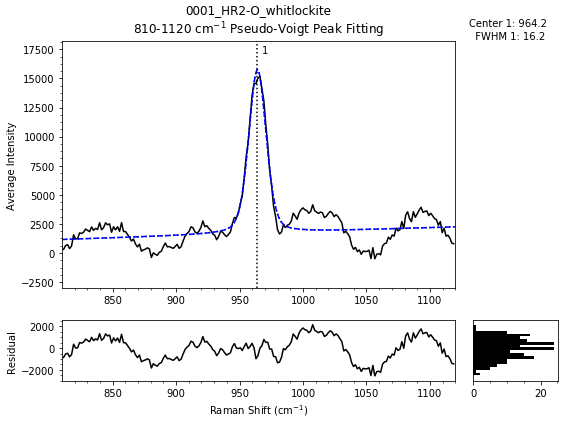

total 1 peaks fitted across 1 spectra
saving peak fit data to file


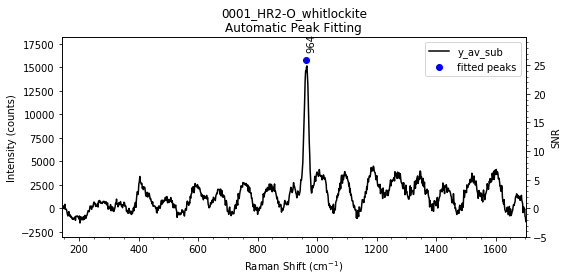

    done!

2/7 fitting peaks for 0003_HR2-O_dentine
    detected peaks: 428, 581, 639, 823, 961, 1073, 1113, 1185, 1244, 1299, 1458

running peak fitting on measurement 0003_HR2-O_dentine


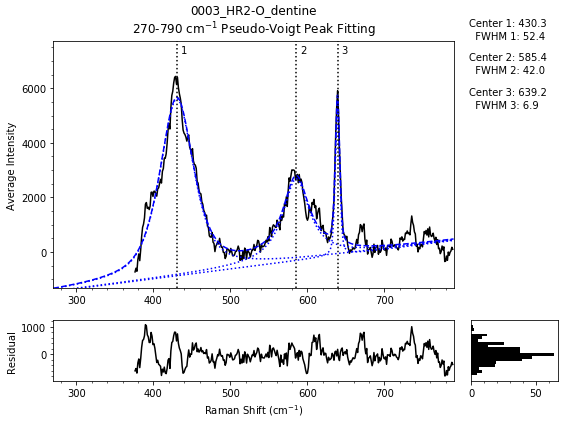

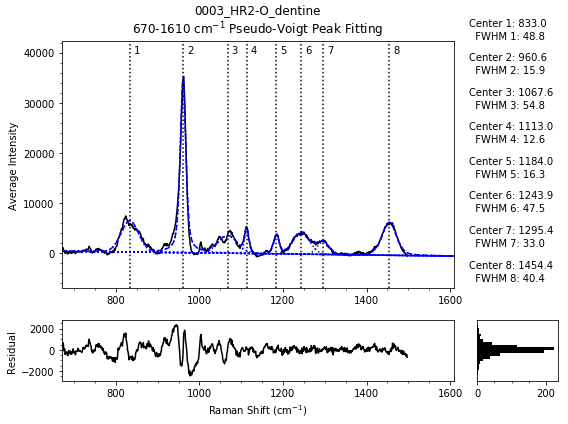

total 11 peaks fitted across 1 spectra
saving peak fit data to file


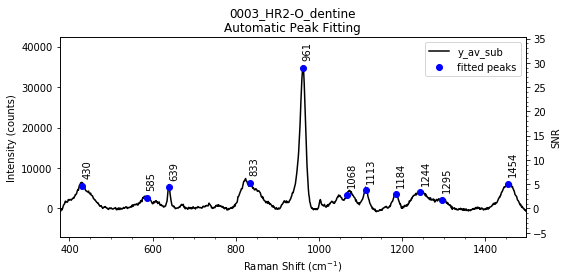

    done!

3/7 fitting peaks for 0004_HR2-O_whitlockite
    detected peaks: 406, 626, 966

running peak fitting on measurement 0004_HR2-O_whitlockite


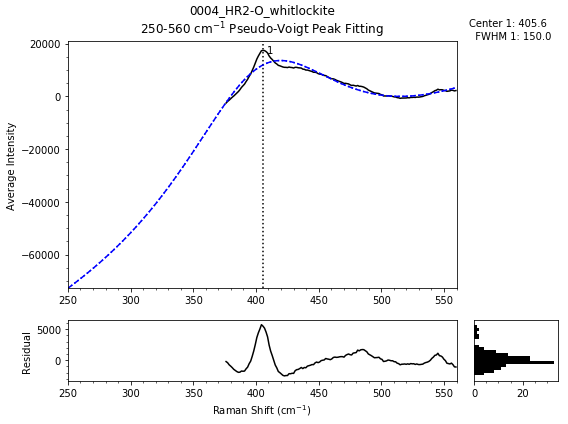

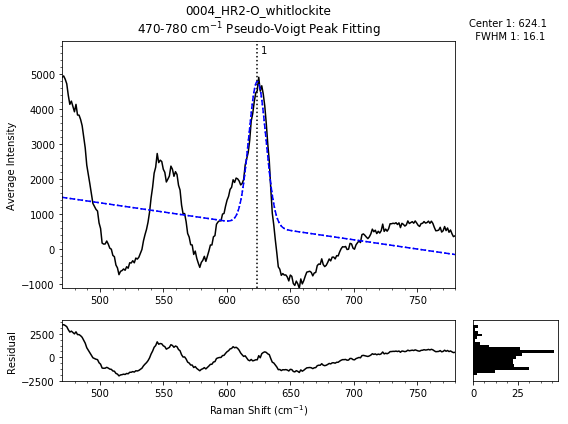

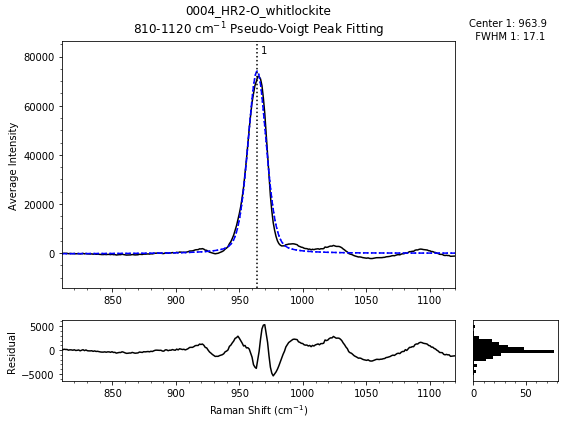

total 3 peaks fitted across 1 spectra
saving peak fit data to file


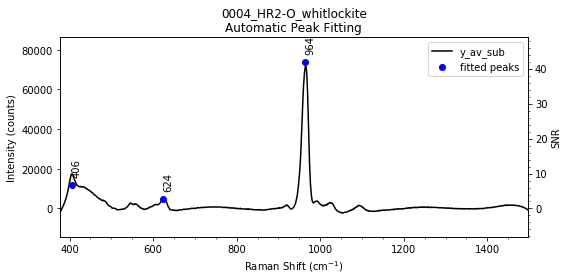

    done!

4/7 fitting peaks for 0005_HR2-O_map1
    detected peaks: 406, 638, 822, 966, 1112, 1185, 1249, 1300, 1459

running peak fitting on measurement 0005_HR2-O_map1


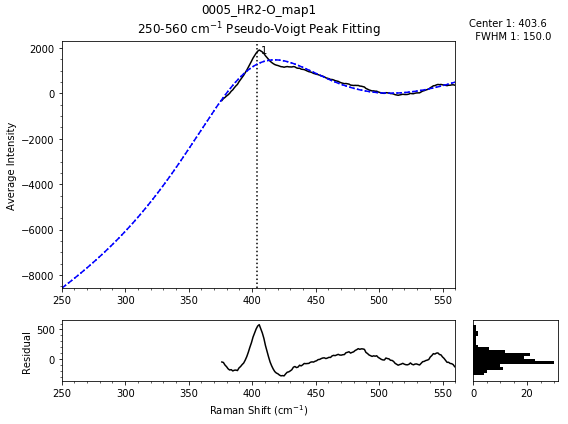

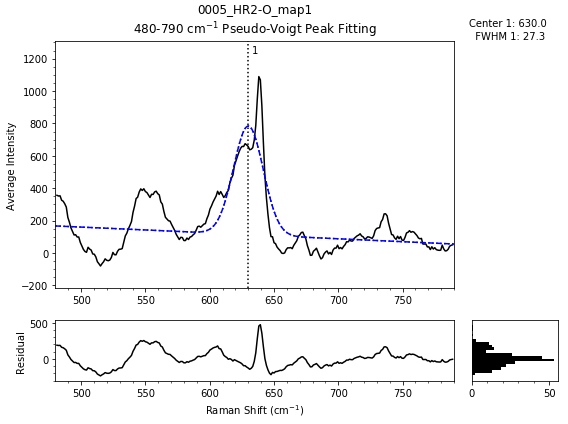

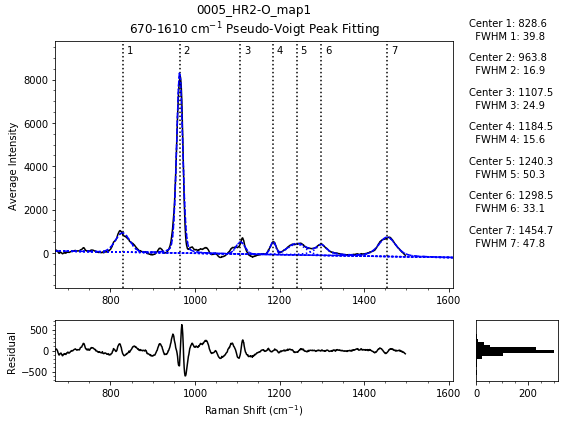

total 9 peaks fitted across 1 spectra
saving peak fit data to file


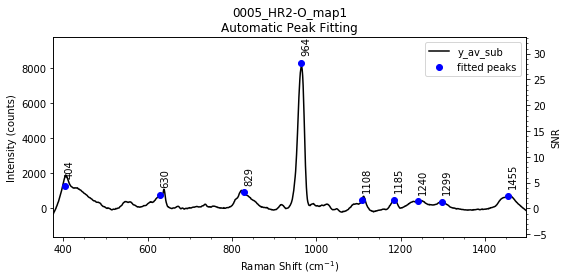

    done!

5/7 fitting peaks for 0006_HR2-O_map2
    detected peaks: 428, 962, 1243, 1452

running peak fitting on measurement 0006_HR2-O_map2


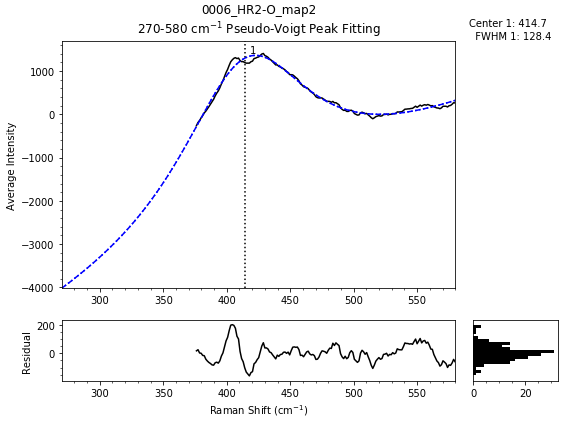

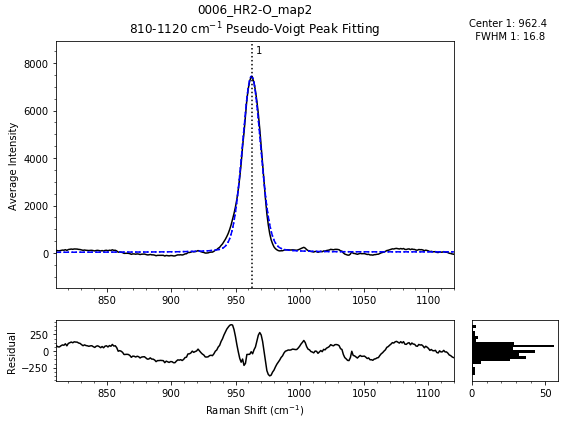

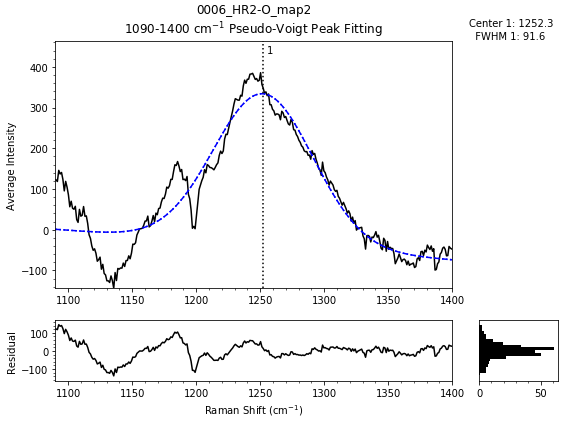

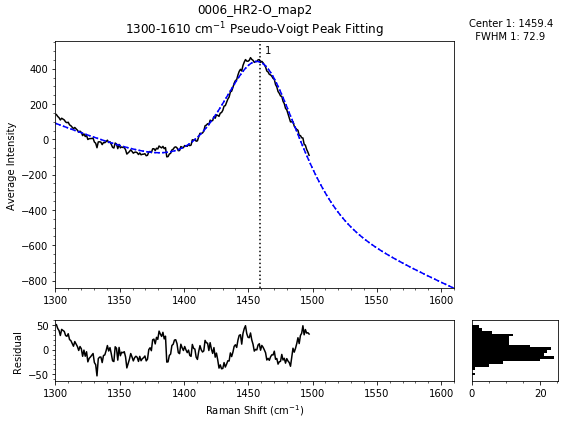

total 4 peaks fitted across 1 spectra
saving peak fit data to file


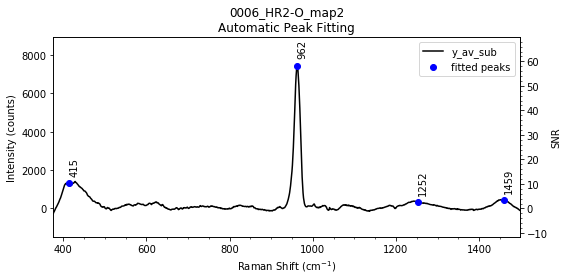

    done!

6/7 fitting peaks for 0007_HR2-O_map3
    detected peaks: 428, 962

running peak fitting on measurement 0007_HR2-O_map3


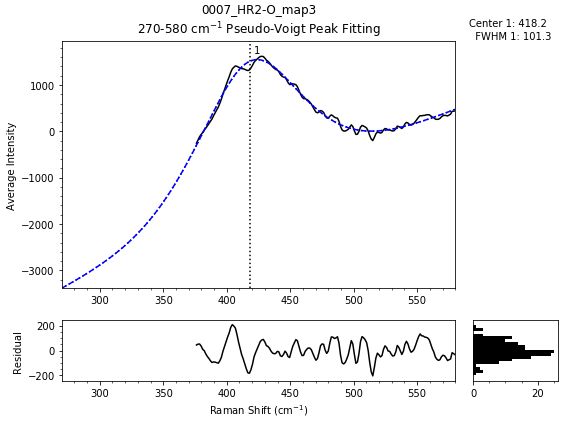

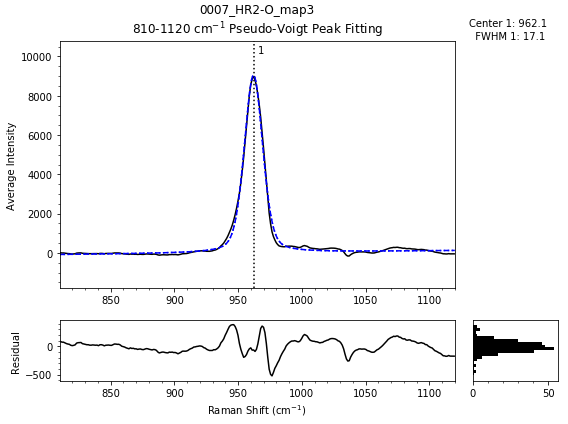

total 2 peaks fitted across 1 spectra
saving peak fit data to file


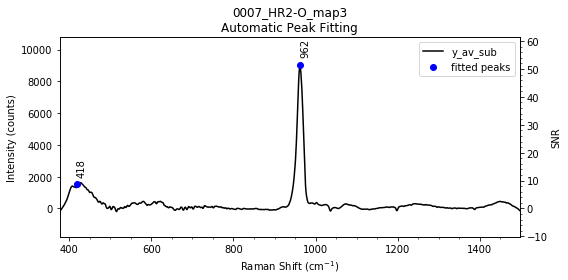

    done!

7/7 fitting peaks for 0008_HR2-O_resin
    detected peaks: 572, 639, 822, 915, 1049, 1112, 1185, 1249, 1300, 1460

running peak fitting on measurement 0008_HR2-O_resin


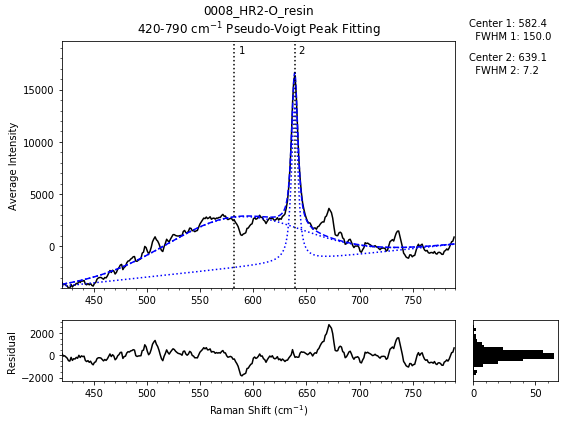

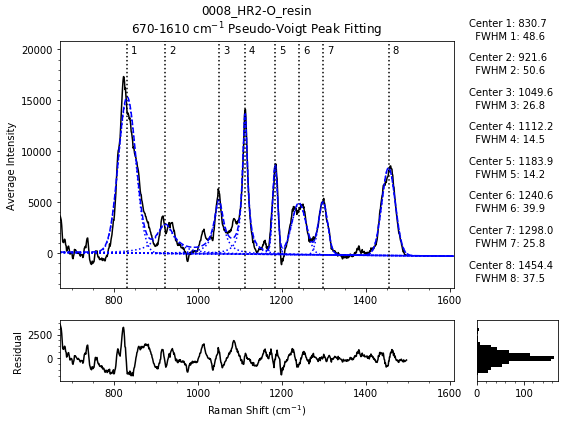

total 10 peaks fitted across 1 spectra
saving peak fit data to file


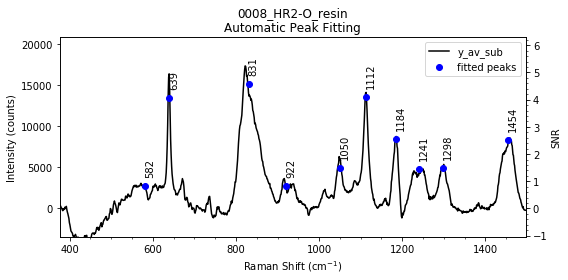

    done!


In [12]:
if skip == True:
    print("SKIPPING AUTOMATIC PEAK FITTING")
else:
    print("DOING AUTOMATIC PEAK FITTING")

    if len(Spec_IDs) == 0:
        print("    no spectra imported, skipping")

    process_count = 1
    for ID, measurement in data.items():
        title = measurement.title
        sample = measurement.sample
        print()
        print("%s/%s fitting peaks for %s" % (process_count, len(data.keys()), measurement.title))

        if hasattr(measurement, y_key) == True:
            temp = y_key
        else:
            temp = alt_key

        if ID in Manual_Peaks:
            positions = Manual_Peaks[ID]
            print("    specified peaks:", ", ".join(["%0.f" % i for i in positions]))
        elif hasattr(measurement, 'detected-peaks'):
            positions = measurement['detected-peaks'].loc[:,'centers']
            print("    detected peaks:", ", ".join(["%0.f" % i for i in positions]))
        else:
            positions = []
            print("    no peak positions specified")

        fit_peaks(measurement, x_key, temp, new_key, function=Fit_Function, peak_positions=positions,
                  show_plot=show_plot, save_plot=save_plot, debug=debug)
        process_count += 1
        
        # if map
        
        print("    done!")

# Plot Results by Sample

plotting sample summaries
['', '', '', '', '', '', '']


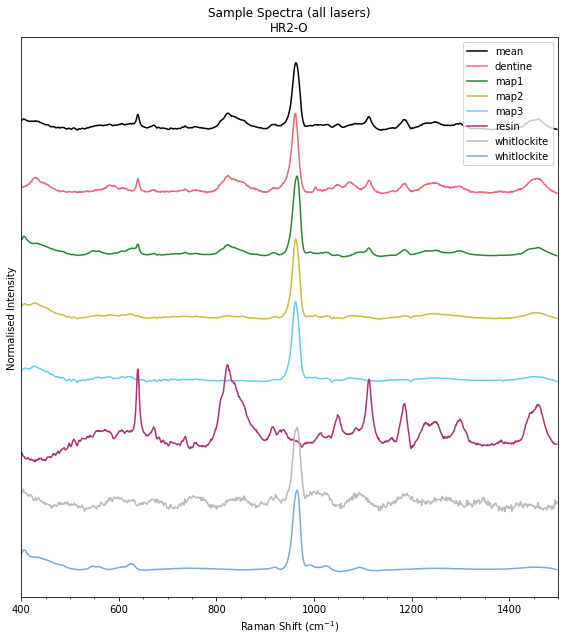

In [13]:
# set whether to print debug messages in this section
debug = False

# keyname for x values to plot ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname for y values to plot
y_key = 'y_av_sub_refsub'

# alternate y key if y_key does not exist for a given measurement
alt_key = 'y_av_sub'

# label for X axis
x_label = "Raman Shift (cm$^{-1}$)"

# label for Y axis
y_label = 'Normalised Intensity'

# X range for plotting
x_start, x_end = (400, 1500)

# normalise data before plotting?
normalise = True

# offset spectra by this much (0 for no offset)
offset = 0.8

# plot average spectrum as well?
plot_average = True

print("plotting sample summaries")

if Laser_Wavelength == '*':
    text = 'all-lasers'
    titletext = 'all lasers'
else:
    text = '%snm' % Laser_Wavelength
    titletext = '%snm' % Laser_Wavelength

# plot sample spectra
for sample in samples:
    result = np.asarray([ID for ID, measurement in data.items() if measurement.sample == sample])
    print([data[ID].notes for ID in result])
    sort = np.lexsort(([data[ID].subsample for ID in result], [data[ID].notes for ID in result]))
    result = result[sort]
    count = 0
    
    plt.figure(figsize=(8,2+len(result)))
    plt.title("Sample Spectra (%s)\n%s" % (titletext, sample))
    plt.xlabel(x_label)
    plt.xlim(x_start, x_end)
    if offset != 0:
        plt.ylabel(y_label)
        plt.yticks([])
    else:
        plt.ylabel(y_label)
    
    if plot_average == True:
        # plot average spectrum
        x, y = average_spectra([data[ID] for ID in result], x_key, y_key, alt_key, start=x_start, end=x_end,
                normalise=normalise, debug=debug)
        plt.plot(x, y - count*offset, 'k', label='mean')
        count += 1
        
    for ID in result:
        measurement = data[ID]
        # check which key to use
        if hasattr(measurement, y_key) == True:
            key = y_key
        else:
            key = alt_key
        # plot each measurement separately
        x, y = get_plot_data(data[ID], x_key, key, x_start, x_end, normalise=normalise, debug=debug)
        label = str(data[ID].subsample)
        plt.plot(x, y - count*offset, Colour_List[count % len(Colour_List)], label=label)
        count += 1
    plt.legend(loc=1)
    plt.minorticks_on()
    plt.tight_layout()
    plt.savefig("%s%s/%s_%s_spectra.png" % (Fig_dir, sample, sample, text), dpi=300)
    plt.show()

# Compare Samples with the same label
- this section groups spectra according to a specified property and plots comparison figures for each group

In [14]:
# skip this section?
skip = False

# set whether to print debug messages in this section
debug = False

# keyname for x values to plot ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use
y_key = 'y_av_sub'

# back-up keyname if y_key does not exist
alt_key = 'y_av_sub'

# label for X axis
x_label = "Raman Shift (cm$^{-1}$)"

# label for Y axis
y_label = 'Normalised Intensity'

# X range for plotting
x_start, x_end = (500, 1500)

# normalise data before plotting?
normalise = True

# offset spectra by this much (0 for no offset)
offset = 0.4

# group spectra by this parameter
grouping = 'sample'

# plot average spectra?
plot_average = True

PLOTTING SAMPLE COMPARISONS

1 groups found: ['HR2-O']

plotting group HR2-O, 7 spectra found


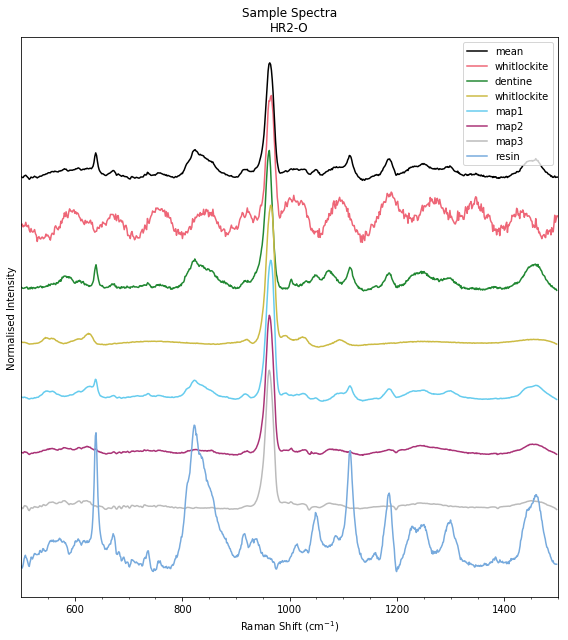

In [15]:
if skip == True:
    print("SKIPPING SAMPLE COMPARISON")
else:
    print("PLOTTING SAMPLE COMPARISONS")

    # get groupings
    groups = list(np.unique([measurement[grouping] for ID, measurement in data.items() if hasattr(measurement, grouping)]))
    print()
    print("%s groups found:" % len(groups), groups)
    
    # plot spectra for each group separately
    for group in groups:
        result = [ID for ID, measurement in data.items() if getattr(measurement, grouping, "") == group]
        spec_count = len(result)
        print()
        print("plotting group %s, %s spectra found" % (group, spec_count))
        if debug == True:
            print("    ", result)
        
        count = 0

        if offset != 0:
            plt.figure(figsize=(8,2+len(result)))
        else:
            plt.figure(figsize=(8,4))
        plt.title("Sample Spectra\n%s" % group)
        plt.xlabel(x_label)
        plt.xlim(x_start, x_end)
        if offset > 0:
            plt.ylabel(y_label)
            plt.yticks([])
        else:
            plt.ylabel(y_label)

        # plot average spectra
        count = 0
        if plot_average == True and spec_count > 1:
            x, y = average_spectra([data[ID] for ID in result], x_key, y_key, alt_key, start=x_start, end=x_end,
                                  normalise=normalise, debug=debug)
            plt.plot(x, y - count*offset, 'k', label='mean', zorder=3)
            count += 1

        # plot individual spectra
        for ID in result:
            measurement = data[ID]
            # check which key to use
            if hasattr(measurement, y_key) == True:
                key = y_key
            else:
                key = alt_key
            
            # get data
            x, y = get_plot_data(data[ID], x_key, key, start=x_start, end=x_end,
                    normalise=normalise, debug=debug)
            
            if offset != 0:
                alpha=1.
            else:
                1./np.sqrt(spec_count)
            
            # plot spectra
            if len(result) < 10:
                # plot individual spectra as distinct lines with their own labels
                plt.plot(x, y - count*offset, Colour_List[count % len(Colour_List)],
                         alpha=alpha, label="%s" % (measurement.subsample))
            else:
                # too many spectra to label individually, plot all spectra as semi-transparent lines of the same colour
                plt.plot(x, y - count*offset, Colour_List[groups.index(group) % len(Colour_List)],
                         alpha=alpha)
            count += 1
            
        plt.legend(loc=1)
        plt.minorticks_on()
        plt.tight_layout()
        plt.savefig("%s%s_summary.png" % (Fig_dir, group), dpi=300)
        plt.savefig("%s%s_summary.svg" % (Fig_dir, group), dpi=300)
        plt.show()

# Compare Samples with different labels
- this section groups spectra according to a specified property and plots comparison figures for group averages

In [16]:
# skip this section?
skip = False

# set whether to print debug messages in this section
debug = False

# keyname for x values to plot ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname for y values to plot
y_key = 'y_av_sub_refsub'

# keyname for y values to plot
y_key = 'y_av_sub_refsub'

# back-up keyname if y_key does not exist
alt_key = 'y_av_sub'

# label for X axis
x_label = "Raman Shift (cm$^{-1}$)"

# label for Y axis
y_label = 'Normalised Intensity'

# X range for plotting
x_start, x_end = (500, 1500)

# normalise data before plotting?
normalise = True

# offset spectra by this much (0 for no offset)
offset = 0.4

# group spectra by this parameter
grouping = 'sample'

# plot average spectra?
plot_average = True

PLOTTING SAMPLE COMPARISONS

1 groups found: ['HR2-O']


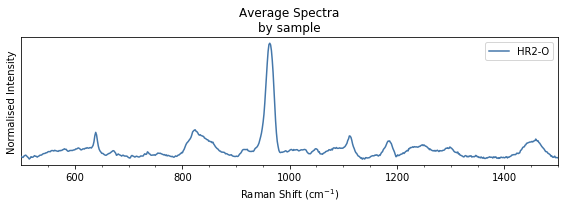

In [17]:
if skip == True:
    print("SKIPPING SAMPLE COMPARISON")
else:
    print("PLOTTING SAMPLE COMPARISONS")

    # get groupings
    groups = list(np.unique([measurement[grouping] for ID, measurement in data.items() if hasattr(measurement, grouping)]))
    print()
    print("%s groups found:" % len(groups), groups)
        
    if offset != 0:
        plt.figure(figsize=(8,2+len(groups)))
    else:
        plt.figure(figsize=(8,4))
    plt.title("Average Spectra\nby %s" % grouping)
    plt.xlabel(x_label)
    plt.xlim(x_start, x_end)
    if offset != 0:
        plt.ylabel(y_label)
        plt.yticks([])
    else:
        plt.ylabel(y_label)
        
    count = 0

    # plot spectra for each group separately
    for group in groups:
        result = [ID for ID, measurement in data.items() if getattr(measurement, grouping, "") == group]
        spec_count = len(result)
        
        x, y = average_spectra([data[ID] for ID in result], x_key, y_key, alt_key, start=x_start, end=x_end,
                    normalise=normalise, debug=debug)
        plt.plot(x, y - count*offset, Colour_List[count % len(Colour_List)], label=group, zorder=3)
        count += 1

    plt.legend(loc=1)
    plt.minorticks_on()
    plt.tight_layout()
    if save_plot == True:
        plt.savefig("%s%s_summary.png" % (Fig_dir, grouping), dpi=300)
    if show_plot == True:
        plt.show()
    else:
        plt.close()

# Plot linescans

In [18]:
# skip this section?
skip = False

# set whether to print debug messages in this section
debug = False

# keyname for x values to plot ('raman_shift', 'wavelength', 'frequency')
x_key = 'raman_shift'

# keyname of y value parameter to use
y_key = 'y_sub'

# label for X axis
x_label = "Raman Shift (cm$^{-1}$)"

# label for Y axis of ax1
y1_label = 'Normalised Intensity'

# spectral property to plot in ax2
prop = ['map-fits', 'centers', 960]

# label for Y axis of ax2
y2_label = 'Peak Position (cm$^{-1}$)'

# X range for plotting
x_start, x_end = (850, 1150)

# normalise data before plotting?
normalise = True

# offset spectra by this much (0 for no offset)
offset = 0.

# select colourmap (see matplotlib see options)
colourmap = 'viridis'

DOING LINESCAN ANALYSIS

doing fits point by point...

running peak fitting on measurement 0005_HR2-O_map1
total 80 peaks fitted across 80 spectra
saving peak fit data to file

plotting linescan 0005 (80 points)
    mean step size: 10.0
(80,) (80,) (80,) (80,)
first 30% values: 963.8 +/- 0.0
 last 30% values: 963.8 +/- 0.1


/Users/joby/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


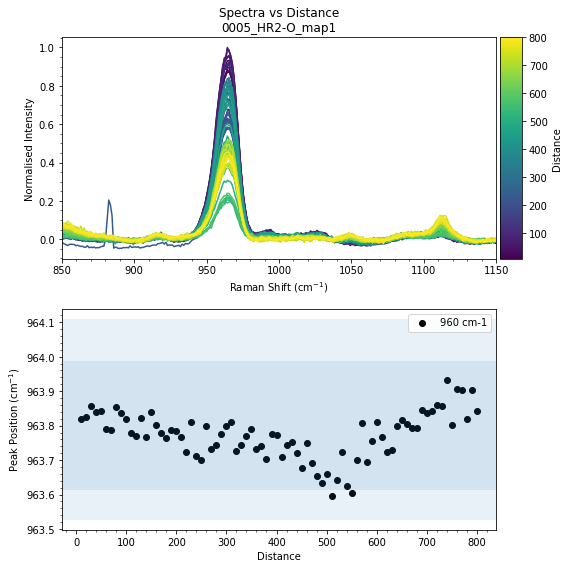


doing fits point by point...

running peak fitting on measurement 0006_HR2-O_map2
total 42 peaks fitted across 42 spectra
saving peak fit data to file

plotting linescan 0006 (42 points)
    mean step size: 10.0
(42,) (42,) (42,) (42,)
first 30% values: 964.0 +/- 0.1
 last 30% values: 960.7 +/- 0.1
transition region: 130.0 - 210.0 um
            width: 80.0 um


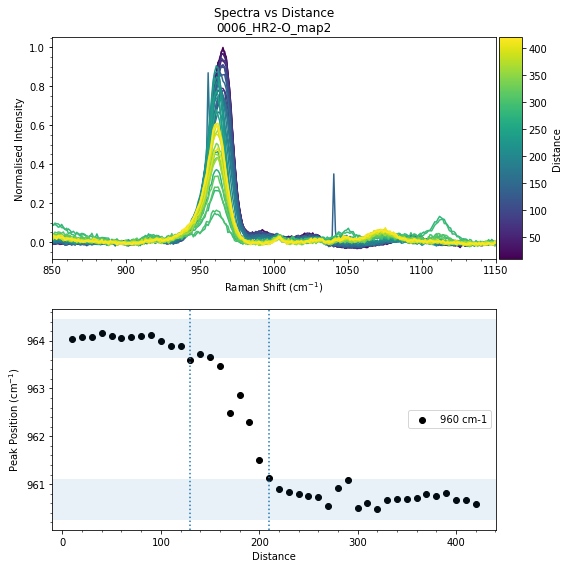


doing fits point by point...

running peak fitting on measurement 0007_HR2-O_map3
total 215 peaks fitted across 215 spectra
saving peak fit data to file

plotting linescan 0007 (215 points)
    mean step size: 1.0
(215,) (215,) (215,) (215,)
first 30% values: 964.0 +/- 0.1
 last 30% values: 960.4 +/- 0.1
transition region: 84.0 - 118.0 um
            width: 34.0 um


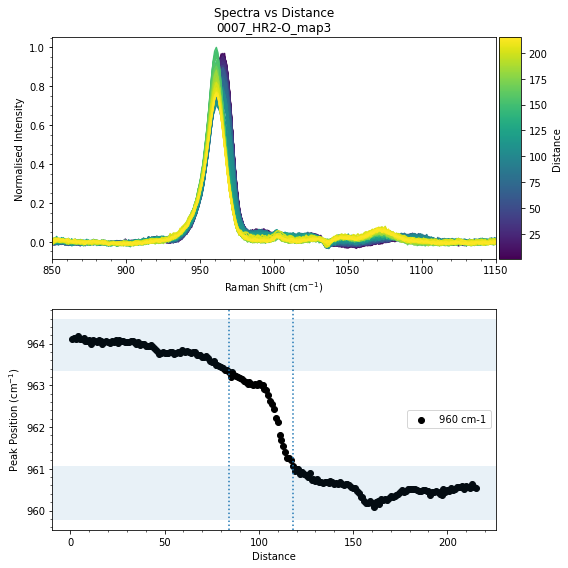

In [29]:
def get_fitted_peak(measurement, key, prop=None, peak_index=None, position=None, spec_index=None, debug=False):
    # function for returning a particular fitted peak property from one or more measurement instances
    output = []
    if hasattr(measurement, key) == False:
        raise Exception("no %s data for measurement %s!" % (key, measurement.title))
    else:
        peak_data = getattr(measurement, key)
        spec_indices = np.unique(peak_data['spec_index'])
        for i in spec_indices:
            # for each fitted spectrum, get required info
            temp = peak_data[peak_data['spec_index'] == i]
            # find appropriate row index
            if peak_index != None:
                # use peak index, starting at lowest index for this spec
                index = temp.index.values[peak_index]
            elif position != None:
                # get peak nearest to specified position
                index = np.argmin(np.abs(temp['centers'] - float(position)))
            if prop != None:
                # return specified column, index
                temp = temp.loc[index, prop]
            else:
                # return specified index, all columns
                temp = temp.loc[index]
            output.append(np.asarray(temp))
    return np.asarray(output)

if skip == True:
    print("SKIPPING LINESCAN ANALYSIS")
else:
    print("DOING LINESCAN ANALYSIS")
    
    for ID, measurement in data.items():
        if measurement.spec_type == 'line':
            print()
            print("doing fits point by point...")
            
            fit_peaks(measurement, x_key, 'y_sub', 'map-fits', function=Fit_Function, peak_positions=[970],
                  show_plot=False, save_plot=False, debug=debug)
            
            print()
            print("plotting linescan %s (%s points)" % (ID, measurement.points))
            
            # get coordinates
            x_coords = measurement.x_coords - measurement.x_coords[0]
            y_coords = measurement.y_coords - measurement.y_coords[0]
            dx = np.gradient(x_coords)
            dy = np.gradient(y_coords)
            steps = np.sqrt(dx**2 + dy**2)
            total_distance = np.cumsum(steps)
            print("    mean step size: %0.1f" % (np.mean(steps)))
            print(np.shape(x_coords), np.shape(y_coords), np.shape(steps), np.shape(total_distance))
            
            # generate colourmap based on distance
            norm = mpl.colors.Normalize(vmin=np.amin(total_distance), vmax=np.amax(total_distance))
            cmap = mpl.cm.ScalarMappable(norm=norm, cmap=getattr(mpl.cm, colourmap))
            cmap.set_array([])
            
            plt.figure(figsize=(8,8))
            # set up ax1, spectra vs distance
            ax1 = plt.subplot2grid((2,1), (0,0))
            ax1.set_title("Spectra vs Distance\n%s" % measurement.title)
            ax1.set_xlabel(x_label)
            ax1.set_ylabel(y1_label)
            ax1.set_xlim(x_start, x_end)
            ax1.minorticks_on()
            # set up ax2, spectral property vs distance
            ax2 = plt.subplot2grid((2,1), (1,0))
            ax2.set_xlabel("Distance")
            ax2.set_ylabel(y2_label)
            ax2.minorticks_on()
            
            # get spectral data
            x, y = get_plot_data(measurement, x_key, y_key, start=x_start, end=x_end, average=False,
                                 normalise=normalise, debug=debug)
            
            # plot spectra in ax1
            count = 0
            for i in range(measurement.points):
                ax1.plot(x, y[:,i] + offset*count, c=cmap.to_rgba(total_distance[i]))
                count += 1
                
            # add colour bar to ax1
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            plt.colorbar(cmap, label="Distance", cax=cax)
            divider = make_axes_locatable(ax2)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cax.set_visible(False)
            
            
            # get spectral property data
            if prop[0] in ['map-fits', 'fitted_peaks']:
                y_values = get_fitted_peak(measurement, prop[0], prop=prop[1], position=prop[2], debug=True)
            if prop[1] in ['centers', 'centers_err', 'fwhm', 'fwhm_err', 'sigmas', 'sigmas_err', 'gammas', 'gammas_err']:
                text = 'cm-1'
                
            first = y_values[:int(0.3*len(y_values))]
            last = y_values[-int(0.3*len(y_values)):]
            print("first 30%% values: %0.1f +/- %0.1f" % (np.mean(first), np.std(first)))
            print(" last 30%% values: %0.1f +/- %0.1f" % (np.mean(last), np.std(last)))
            
            # plot spectral property in ax2
            ax2.scatter(total_distance, y_values, c='k', label="%s %s" % (prop[2], text))
            
            # plot start and end region ranges (+/- 1 st. dev.)
            sigma = 5
            ax2.axhspan(np.mean(first)-sigma*np.std(first), np.mean(first)+sigma*np.std(first), alpha=0.1)
            ax2.axhspan(np.mean(last)-sigma*np.std(last), np.mean(last)+sigma*np.std(last), alpha=0.1)
            
            # plot transition region
            start = y_values < np.mean(first)-sigma*np.std(first)
            end = y_values > np.mean(last)+sigma*np.std(last)
            if np.count_nonzero(np.logical_and(start, end)) > 0:
                ax2.axvline(total_distance[start][0], linestyle=':')
                ax2.axvline(total_distance[end][-1], linestyle=':')
                print("transition region: %0.1f - %0.1f um" % (total_distance[start][0], total_distance[end][-1]))
                print("            width: %0.1f um" % (total_distance[end][-1] - total_distance[start][0]))
            
            # finish figure
            ax2.legend()
            plt.tight_layout()
            if save_plot == True:
                plt.savefig("%s%s_fitted-%s-v-distance.png" % (measurement.fig_dir, measurement.title, prop[1]), dpi=300)
                plt.savefig("%s%s_fitted-%s-v-distance.svg" % (measurement.fig_dir, measurement.title, prop[1]), dpi=300)
            if show_plot == True:
                plt.show()
            else:
                plt.close()

PLOTTING MAPS
(80, 4) (20, 400, 4)


/Users/joby/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


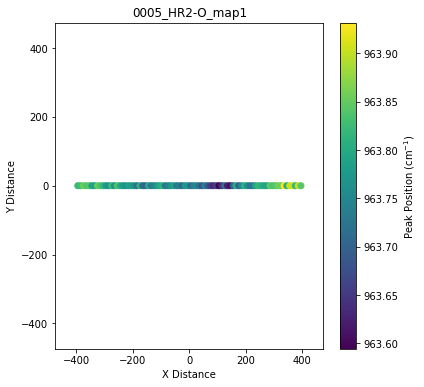

(42, 4) (20, 210, 4)


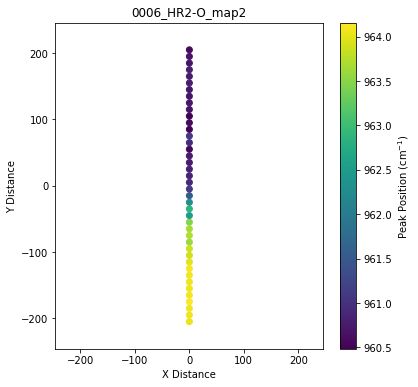

(215, 4) (20, 1075, 4)


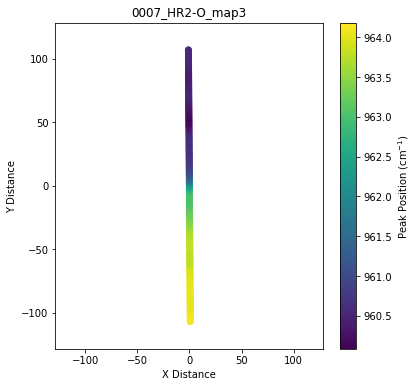

In [20]:

if skip == True:
    print("SKIPPING MAP PLOTS")
else:
    print("PLOTTING MAPS")
    
    # generate 2D scatter plot based on x,y coordinates
    for ID, measurement in data.items():
        if measurement.spec_type in ['map', 'line']:
            # get coordinates
            x_coords = measurement.x_coords - np.mean(measurement.x_coords)
            y_coords = measurement.y_coords - np.mean(measurement.y_coords)
            axmin = 1.2*np.min([x_coords, y_coords])
            axmax = 1.2*np.max([x_coords, y_coords])
            
            # get spectral property data
            if prop[0] in ['map-fits', 'fitted_peaks']:
                y_values = get_fitted_peak(measurement, prop[0], prop=prop[1], position=prop[2], debug=True)
                
            # generate colourmap based on y_value
            norm = mpl.colors.Normalize(vmin=np.amin(y_values), vmax=np.amax(y_values))
            cmap = mpl.cm.ScalarMappable(norm=norm, cmap=getattr(mpl.cm, colourmap))
            cmap.set_array([])
            
            # generate colours for y_value array
            colour_map = np.asarray([cmap.to_rgba(val) for val in y_values])
            
            # save colour map as separate image
            if save_plot == True:
                if colour_map.ndim == 2:
                    img = np.repeat(np.repeat(colour_map[np.newaxis,:,:], 20, axis=0), 5, axis=1)
                else:
                    img = np.repeat(np.repeat(colour_map, 5, axis=0), 5, axis=1)
                print(np.shape(colour_map), np.shape(img))
                plt.imsave('%s%s_img.png' % (measurement.fig_dir, measurement.title), img)
            
            # generate figure for map, using (x,y) coordinates
            plt.figure(figsize=(6,6))
            ax = plt.subplot(111)
            ax.set_title(measurement.title)
            ax.set_xlabel("X Distance")
            ax.set_ylabel("Y Distance")
            ax.set_xlim(axmin, axmax)
            ax.set_ylim(axmin, axmax)
            ax.scatter(x_coords, y_coords, c=colour_map)
            plt.colorbar(cmap, label=y2_label)
            if save_plot == True:
                plt.savefig("%s%s_map.png" % (measurement.fig_dir, measurement.title), dpi=300)
                plt.savefig("%s%s_map.svg" % (measurement.fig_dir, measurement.title), dpi=300)
            if show_plot == True:
                plt.show()
            else:
                plt.close()

# Save Processed Spectra
- for all measurements, the average spectrum is saved to _av-spectrum.csv
    - includes columns for raw intensity, baselined intensity, and normalised values
- for multi-spec measurements (e.g. maps and line-scans), all point-spectra are saved to _all-spectra_baselined.csv
    - each spectrum is saved as a column along with its X,Y coordinates

In [21]:
# skip this section?
skip = False

# print debug messages in viewer?
debug = False

# save metadata to dedicated file? (recommended)
save_metadata = True
    
if skip == True:
    print("SKIPPING SAVE TO FILE STEP")
else:
    print("SAVING PROCESSED SPECTRA TO OUTPUT FOLDER")

    process_count = 1
    for ID, measurement in data.items():
        title = measurement.title
        print()
        print("%s/%s saving spectrum %s" % (process_count, len(data.keys()), measurement.title))

        # one column for each modification of spectrum
        headers = ['Wavelength (nm)', 'Raman Shift (cm-1)', 'Raw Intensity', 'Normalised Intensity',
                   'Baselined Intensity', 'Normalised Baselined Intensity']
        if hasattr(measurement, 'y_av_sub_refsub'):
            print("    using y_av_sub_refsub")
            print("        log:", ", ".join(measurement['y_av_sub_refsub'].log))
            keys = ['wavelength', 'raman_shift', 'y_av', 'y_av_norm', 'y_av_sub_refsub', 'y_av_sub_refsub_norm']
        else:
            print("    using y_av_sub")
            keys = ['wavelength', 'raman_shift', 'y_av', 'y_av_norm', 'y_av_sub', 'y_av_sub_norm']
        save_measurement(measurement, keys=keys, headers=headers, save_name='av-spectrum', debug=debug)

        # save all point-spectra to file (maps & multi-spec files only)
        if measurement.points > 1 and hasattr(measurement, 'y_sub'):
            # one column per baselined point-spectrum
            headers = ['Wavelength (nm)', 'Raman Shift (cm-1)', 'Baselined Intensity']
            keys = ['wavelength', 'raman_shift', 'y_sub']
            save_measurement(measurement, keys=keys, headers=headers, save_name='all-spectra-baselined',
                            debug=debug)
        process_count += 1
        print("    saved!")

SAVING PROCESSED SPECTRA TO OUTPUT FOLDER

1/7 saving spectrum 0001_HR2-O_whitlockite
    using y_av_sub_refsub
        log: averaged 1 spectra, baselined using polynomial, oscillation fitted and subtracted, baselined using polynomial
    saved!

2/7 saving spectrum 0003_HR2-O_dentine
    using y_av_sub
    saved!

3/7 saving spectrum 0004_HR2-O_whitlockite
    using y_av_sub
    saved!

4/7 saving spectrum 0005_HR2-O_map1
    using y_av_sub


/Users/joby/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


    saved!

5/7 saving spectrum 0006_HR2-O_map2
    using y_av_sub
    saved!

6/7 saving spectrum 0007_HR2-O_map3
    using y_av_sub
    saved!

7/7 saving spectrum 0008_HR2-O_resin
    using y_av_sub
    saved!


In [22]:
print("SCRIPT COMPLETE!")

SCRIPT COMPLETE!
